In [1]:
#cell 1

import sys, subprocess, importlib, math, os, random, time, copy
import numpy as np

def _pip(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", pkg, "--quiet"], check=False)

# install torchprofile for macs estimation
_pip("torchprofile")
# install grad cam lib
_pip("pytorch-grad-cam")

# imports after install
import torch
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from matplotlib import pyplot as plt
from torchprofile import profile_macs

# seeds for repeatability
SEED = 27100162
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# device selection
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", DEVICE)

# figure settings tuned for two column icml paper
# use a readable serif to mimic icml figure style
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 160,
})

# utility to standardize figure size for two column layout
def fig_two_col(w=6.3, h=3.4):
    # width about two columns on icml page
    # height balanced for clarity
    return plt.figure(figsize=(w, h))

# small helper for timing
def now_ms():
    return round(time.time() * 1000)

print("setup is good to go")


device cuda
setup is good to go


In [2]:
#cell 2
# we use standard train time augmentations crop and flip
# batch size moderate to avoid oom on free colab gpu

import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader

IMG_SIZE = 32
BATCH = 256

# CIFAR-100 channel statistics
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

train_tf = T.Compose([
    T.RandomCrop(IMG_SIZE, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
    T.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value="random"),
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

root_dir = "./data_cifar100"
train_set = datasets.CIFAR100(root=root_dir, train=True,  download=True, transform=train_tf)
test_set  = datasets.CIFAR100(root=root_dir, train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("train size", len(train_set), "test size", len(test_set))


100%|██████████| 169M/169M [00:06<00:00, 28.0MB/s]


train size 50000 test size 10000


In [3]:
# Cell 03 Model VGG11 for CIFAR100

# we build vgg11 bn and replace the classifier head for hundred classes
# optional warm start from imagenet weights

USE_IMAGENET_INIT = False  # set True only if you want to download imagenet weights

if USE_IMAGENET_INIT:
    vgg = models.vgg11_bn(weights=models.VGG11_BN_Weights.IMAGENET1K_V1)
else:
    vgg = models.vgg11_bn(weights=None)

# adjust final classifier
in_feat = vgg.classifier[-1].in_features
vgg.classifier[-1] = nn.Linear(in_feat, 100)

# move to device
vgg = vgg.to(DEVICE)

# quick info
total_params = sum(p.numel() for p in vgg.parameters())
print("vgg11 params", total_params)


vgg11 params 129181540


In [4]:
# Cell 04 Train and evaluate utilities plus measurement helpers

# compact train loop with optional callbacks so pruning masks can be re applied during finetune
# evaluate returns accuracy in percent
# macs and sparsity helpers are provided for reporting and for target setting near seventy percent

@torch.inference_mode()
def evaluate(model, loader, verbose=True):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    acc = 100.0 * correct / total
    if verbose:
        print(f"accuracy {acc:.2f} percent")
    return acc

# (REPLACED): train_one_epoch without per-batch scheduler stepping =====
from torch.optim.lr_scheduler import OneCycleLR

from torch import amp
from torch.optim.lr_scheduler import OneCycleLR

def train_one_epoch(model, loader, optimizer, scheduler=None, criterion=None, callbacks=None):
    model.train()
    loss_meter, n = 0.0, 0
    use_amp = (DEVICE.type == "cuda")
    scaler = amp.GradScaler('cuda') if use_amp else None
    is_onecycle = isinstance(scheduler, OneCycleLR)

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with amp.autocast('cuda'):
                out = model(x)
                loss = (criterion or nn.CrossEntropyLoss())(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(x)
            loss = (criterion or nn.CrossEntropyLoss())(out, y)
            loss.backward()
            optimizer.step()

        if callbacks:
            for cb in callbacks:
                cb()

        if is_onecycle and (scheduler is not None):
            scheduler.step()

        loss_meter += float(loss.item()) * x.size(0)
        n += x.size(0)

    if (scheduler is not None) and (not is_onecycle):
        scheduler.step()

    return loss_meter / max(n, 1)
def measure_latency_ms(model, input_shape=(1,3,32,32), on="cpu", warmup=20, runs=100):
    # we measure forward only latency average
    m = copy.deepcopy(model).to(on)
    m.eval()
    dummy = torch.randn(*input_shape).to(on)
    with torch.inference_mode():
        for _ in range(warmup):
            _ = m(dummy)
        t1 = time.time()
        for _ in range(runs):
            _ = m(dummy)
        t2 = time.time()
    return (t2 - t1) * 1000.0 / runs

def model_bits(model, bits_per_param=32, count_nonzero_only=False):
    total = 0
    for p in model.parameters():
        total += (p.count_nonzero() if count_nonzero_only else torch.numel(p)).item()
    return total * bits_per_param

def tensor_sparsity(t):
    # returns fraction of zeros
    return float(1.0 - (t.count_nonzero().item() / t.numel()))

def model_sparsity(model):
    nnz = 0
    n = 0
    for p in model.parameters():
        nnz += p.count_nonzero().item()
        n += p.numel()
    return 1.0 - (nnz / n)

def model_macs(model, input_shape=(1,3,32,32)):
    return profile_macs(model, torch.randn(*input_shape).to(next(model.parameters()).device))

print("utils ready")


utils ready


In [5]:
# Patch cell fix model_bits to handle both tensor and python int returns

def _to_int(x):
    return int(x.item()) if isinstance(x, torch.Tensor) else int(x)

def model_bits(model, bits_per_param=32, count_nonzero_only=False):
    total = 0
    for p in model.parameters():
        if count_nonzero_only:
            total += _to_int(p.count_nonzero())
        else:
            total += p.numel()
    return total * bits_per_param


In [6]:
# Cell 05 Baseline quick train and baseline metrics

# this is a light warmup to produce a baseline accuracy without heavy compute
# increase EPOCHS for stronger baseline -- for the reader if they have more time
# we save baseline checkpoint to reuse for pruning comparisons

from torch.optim import SGD
from torch.optim.lr_scheduler import OneCycleLR
import torch.backends.cudnn as cudnn

cudnn.benchmark = True  # faster convs on fixed shapes

EPOCHS = 20
MAX_LR = 0.2                 # peak LR for OneCycle
DIV_FACTOR = 25              # initial LR = MAX_LR / DIV_FACTOR
FINAL_DIV_FACTOR = 100
BASE_LR = MAX_LR / DIV_FACTOR

optimizer = SGD(vgg.parameters(), lr=BASE_LR, momentum=0.9, nesterov=True, weight_decay=5e-4)

scheduler = OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,            # warmup ~20% of epochs
    div_factor=DIV_FACTOR,
    final_div_factor=FINAL_DIV_FACTOR
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

print("training baseline (OneCycleLR per-batch, AMP, normalized data)")
best_acc = 0.0
best_state = None
for ep in range(1, EPOCHS + 1):
    loss = train_one_epoch(vgg, train_loader, optimizer, scheduler=scheduler, criterion=criterion)
    acc = evaluate(vgg, test_loader, verbose=False)
    # report current LR (from optimizer)
    cur_lr = optimizer.param_groups[0]["lr"]
    if acc > best_acc:
        best_acc = acc
        best_state = copy.deepcopy(vgg.state_dict())
    print(f"epoch {ep:02d} | loss {loss:.3f} | acc {acc:.2f} | lr {cur_lr:.5f}")

# restore best checkpoint
if best_state is not None:
    vgg.load_state_dict(best_state)

dense_acc = evaluate(vgg, test_loader, verbose=True)
dense_bits = model_bits(vgg)
dense_macs = model_macs(vgg, (1,3,32,32))
print("dense bits", dense_bits, "dense macs", dense_macs)
torch.save(vgg.state_dict(), "vgg11_cifar100_dense.pt")
print("saved baseline to vgg11_cifar100_dense.pt")

training baseline (OneCycleLR per-batch, AMP, normalized data)
epoch 01 | loss 4.229 | acc 8.57 | lr 0.03619
epoch 02 | loss 4.025 | acc 10.13 | lr 0.10419
epoch 03 | loss 3.737 | acc 13.74 | lr 0.17209
epoch 04 | loss 3.467 | acc 20.27 | lr 0.20000
epoch 05 | loss 3.227 | acc 19.96 | lr 0.19806
epoch 06 | loss 3.018 | acc 27.12 | lr 0.19235
epoch 07 | loss 2.858 | acc 27.90 | lr 0.18310
epoch 08 | loss 2.697 | acc 36.04 | lr 0.17065
epoch 09 | loss 2.574 | acc 35.40 | lr 0.15549
epoch 10 | loss 2.481 | acc 34.84 | lr 0.13820
epoch 11 | loss 2.375 | acc 40.96 | lr 0.11944
epoch 12 | loss 2.272 | acc 45.99 | lr 0.09994
epoch 13 | loss 2.180 | acc 47.21 | lr 0.08044
epoch 14 | loss 2.082 | acc 48.97 | lr 0.06169
epoch 15 | loss 1.975 | acc 52.64 | lr 0.04442
epoch 16 | loss 1.842 | acc 55.38 | lr 0.02929
epoch 17 | loss 1.708 | acc 59.73 | lr 0.01687
epoch 18 | loss 1.553 | acc 62.43 | lr 0.00765
epoch 19 | loss 1.422 | acc 64.14 | lr 0.00198
epoch 20 | loss 1.348 | acc 64.61 | lr 0.0000

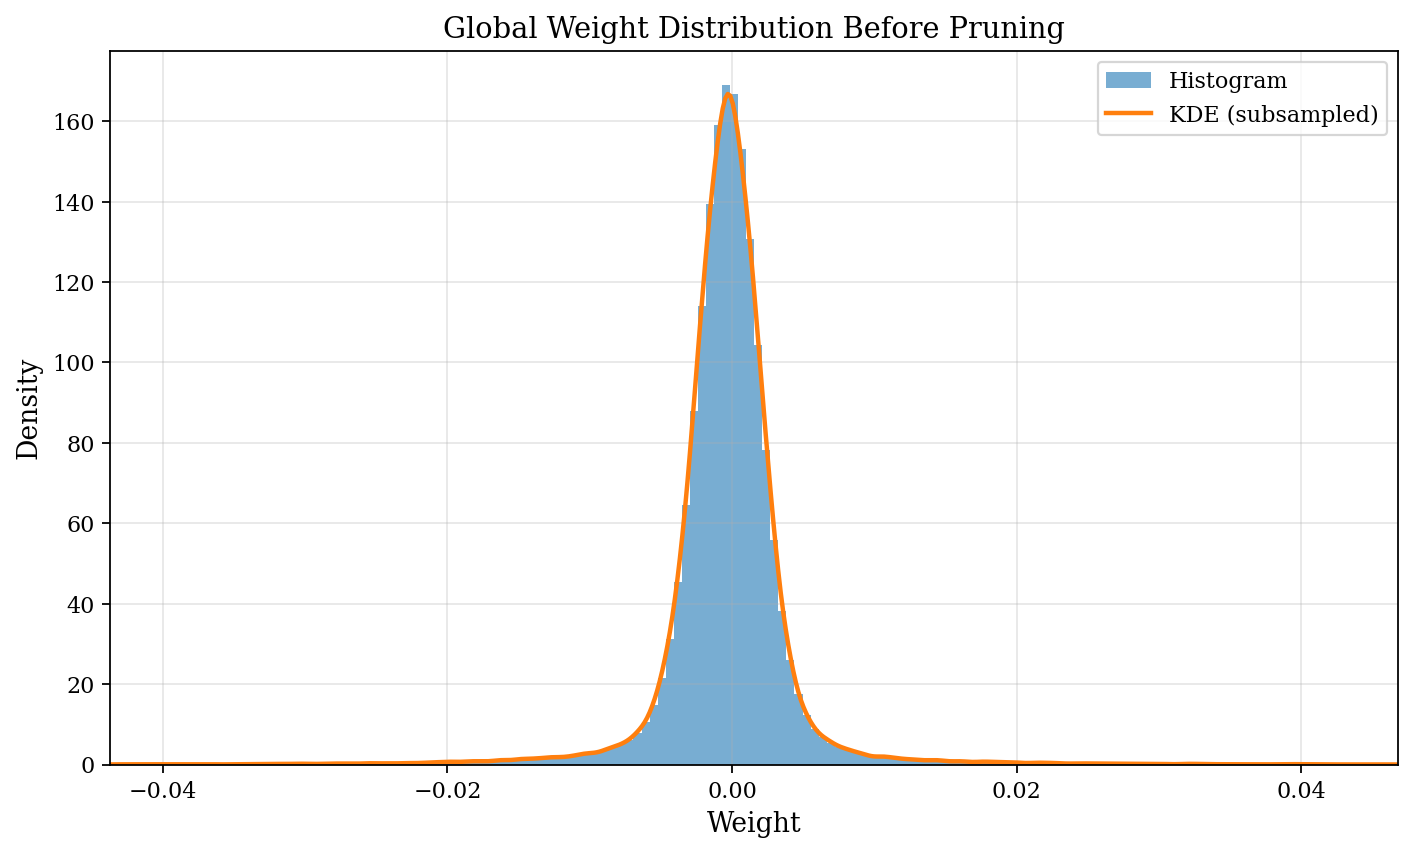

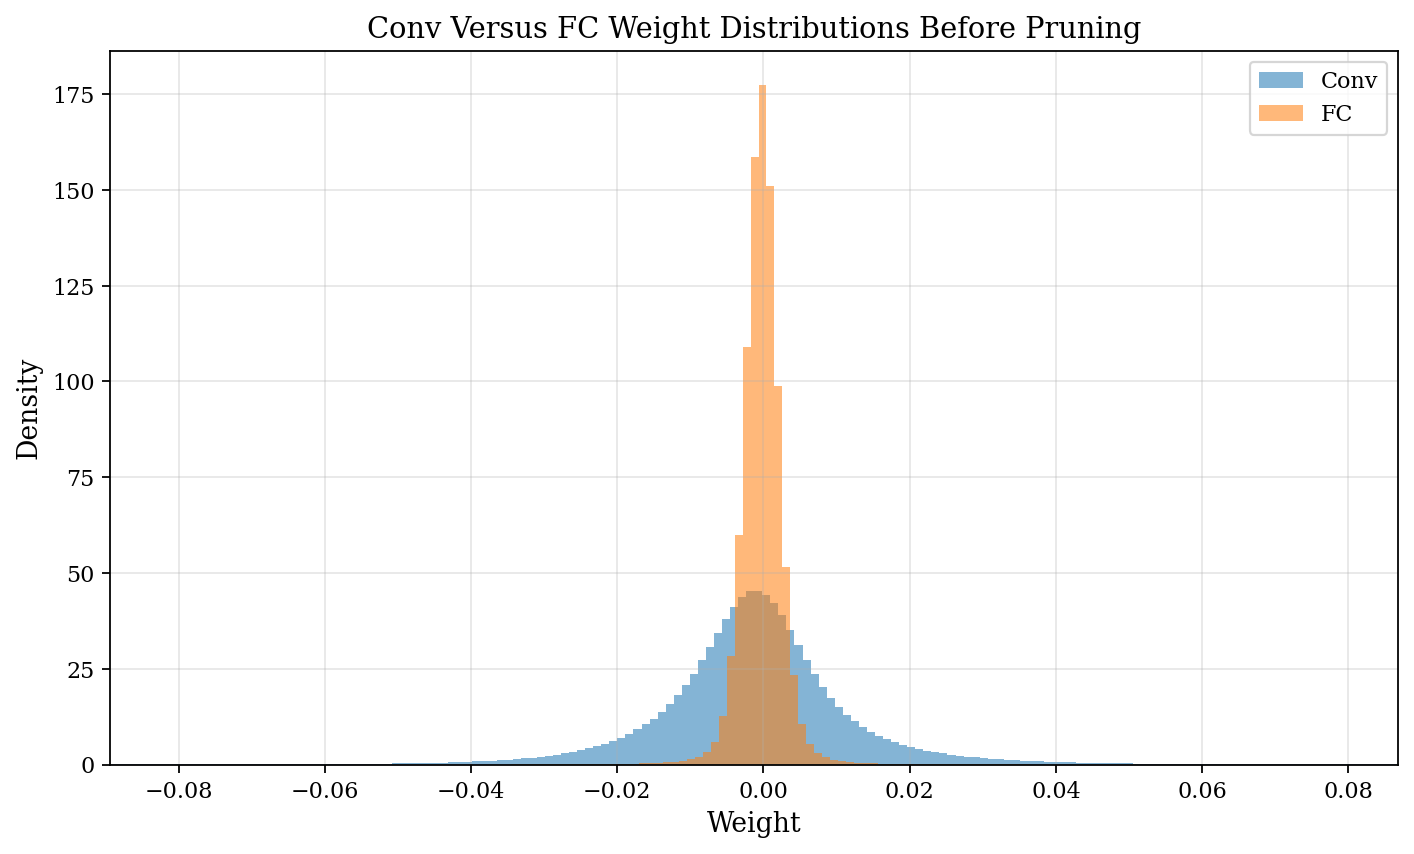

Layer Stats Before Pruning
Layer                                     Mean       Std      Skew   Kurtosis    Sparsity
features.0.weight                      -0.0035    0.2465    -0.129     +2.900      0.000
features.4.weight                      -0.0067    0.0477    -0.082     +6.318      0.000
features.8.weight                      -0.0026    0.0285    +0.120     +1.493      0.000
features.11.weight                     -0.0031    0.0230    +0.303     +1.186      0.000
features.15.weight                     -0.0008    0.0164    +0.240     +0.945      0.000
features.18.weight                     -0.0005    0.0112    +0.300     +1.415      0.000
features.22.weight                     -0.0005    0.0090    +0.051     +2.419      0.000
features.25.weight                     -0.0021    0.0092    +0.426     +4.837      0.000
classifier.0.weight                    -0.0002    0.0023    +0.133     +0.916      0.000
classifier.3.weight                    -0.0004    0.0051    +0.300     +6.488     

In [7]:
# Cell 06 Weight distribution visualization before pruning FAST and readable

# this replaces your entire old Cell 06
# key differences:
# 1 robust x-limits via percentiles to avoid "needle" plots
# 2 KDE computed on a capped random subsample to keep it fast
# 3 clean titles and Capitalized axis labels
# 4 prints a compact per-layer stats table for the report

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

def _collect_weights(model):
    conv, fc, allw = [], [], []
    layer_arrays = {}
    for n, p in model.named_parameters():
        if p.dim() > 1:
            arr = p.detach().view(-1).float().cpu().numpy()
            allw.append(arr)
            if "features" in n or "backbone" in n:
                conv.append(arr)
            elif "classifier" in n or "fc" in n:
                fc.append(arr)
            layer_arrays[n] = arr
    return {
        "all": np.concatenate(allw) if allw else np.array([]),
        "conv": np.concatenate(conv) if conv else np.array([]),
        "fc":   np.concatenate(fc) if fc else np.array([]),
        "layers": layer_arrays,
    }

def _fd_bins(x):
    x = np.asarray(x);
    if x.size == 0: return 80
    q75, q25 = np.percentile(x, [75, 25])
    iqr = max(q75 - q25, 1e-9)
    bw = 2 * iqr * (len(x) ** (-1/3))
    if bw <= 0: return 120
    return int(np.clip((x.max() - x.min()) / bw, 40, 160))

def _robust_xlim(x, lo=0.05, hi=99.95):
    if x.size == 0: return (-1e-6, 1e-6)
    a, b = np.percentile(x, [lo, hi])
    if a == b:
        pad = 1e-6
        return a - pad, b + pad
    return a, b

def _kde_curve(xs, lo, hi, max_points=100_000):
    xs = np.asarray(xs)
    if xs.size == 0: return None, None
    if xs.size > max_points:
        idx = np.random.choice(xs.size, max_points, replace=False)
        xs = xs[idx]
    try:
        kde = st.gaussian_kde(xs)
        grid = np.linspace(lo, hi, 512)
        return grid, kde(grid)
    except Exception:
        return None, None

def plot_global_and_groups_before(model, pclip=(0.05, 99.95), add_kde=True):
    buckets = _collect_weights(model)
    allw, conv, fc = buckets["all"], buckets["conv"], buckets["fc"]

    # Global histogram (+ KDE on subsample)
    plt.figure(figsize=(9, 5.5))
    lo, hi = _robust_xlim(allw, pclip[0], pclip[1])
    xs = allw[(allw >= lo) & (allw <= hi)]
    plt.hist(xs, bins=_fd_bins(xs), density=True, alpha=0.6, label="Histogram")
    if add_kde:
        grid, dens = _kde_curve(xs, lo, hi)
        if grid is not None:
            plt.plot(grid, dens, linewidth=2, label="KDE (subsampled)")
    plt.title("Global Weight Distribution Before Pruning")
    plt.xlabel("Weight"); plt.ylabel("Density")
    plt.xlim(lo, hi); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # Conv vs FC overlay (shared robust window)
    plt.figure(figsize=(9, 5.5))
    lo_c, hi_c = _robust_xlim(conv, pclip[0], pclip[1])
    lo_f, hi_f = _robust_xlim(fc,   pclip[0], pclip[1])
    lo2, hi2 = min(lo_c, lo_f), max(hi_c, hi_f)
    if conv.size:
        xc = conv[(conv >= lo2) & (conv <= hi2)]
        plt.hist(xc, bins=_fd_bins(xc), density=True, alpha=0.55, label="Conv")
    if fc.size:
        xf = fc[(fc >= lo2) & (fc <= hi2)]
        plt.hist(xf, bins=_fd_bins(xf), density=True, alpha=0.55, label="FC")
    plt.title("Conv Versus FC Weight Distributions Before Pruning")
    plt.xlabel("Weight"); plt.ylabel("Density")
    plt.xlim(lo2, hi2); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # Stats table
    print("Layer Stats Before Pruning")
    print("{:<36} {:>9} {:>9} {:>9} {:>10} {:>11}".format(
        "Layer", "Mean", "Std", "Skew", "Kurtosis", "Sparsity"))
    for name, arr in buckets["layers"].items():
        mean = float(arr.mean()); std = float(arr.std())
        skew = float(st.skew(arr, bias=False)); kurt = float(st.kurtosis(arr, bias=False))
        spars = float((arr == 0).mean())
        print("{:<36} {:>+9.4f} {:>9.4f} {:>+9.3f} {:>+10.3f} {:>10.3f}".format(
            name, mean, std, skew, kurt, spars))

# Run
plot_global_and_groups_before(vgg, pclip=(0.05, 99.95), add_kde=True)


In [8]:
# Cell 07 Unstructured pruning primitive and pruner class

# magnitude based pruning with L =2 magnitude on scalar reduces to absolute value
# we implement per tensor mask by k threshold
# pruner stores masks and can re apply during finetune
# we also include a global target adjuster to meet about seventy percent overall sparsity

@torch.no_grad()
def fine_grained_prune_tensor_(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    # clamp target into valid range then compute threshold by kth value
    s = float(max(0.0, min(1.0, sparsity)))
    if s == 0.0:
        return torch.ones_like(tensor, dtype=torch.bool)
    if s >= 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor, dtype=torch.bool)
    flat = tensor.detach().abs().view(-1)
    k = int(round(s * flat.numel()))
    if k <= 0:
        mask = torch.ones_like(flat, dtype=torch.bool)
    else:
        # kthvalue returns k smallest value position one based requested by torch semantics
        thr = flat.kthvalue(k).values
        mask = (flat > thr)
    mask = mask.view_as(tensor)
    tensor.mul_(mask)  # apply in place
    return mask

class FineGrainedPruner:
    def __init__(self, model: nn.Module, layer_sparsity: dict):
        # layer_sparsity maps param name to target sparsity
        self.masks = {}
        with torch.no_grad():
            for name, p in model.named_parameters():
                if p.dim() > 1 and name in layer_sparsity:
                    self.masks[name] = fine_grained_prune_tensor_(p, layer_sparsity[name])

    @torch.no_grad()
    def apply(self, model: nn.Module):
        for name, p in model.named_parameters():
            if name in self.masks:
                p.mul_(self.masks[name])

def layer_param_dict(model):
    # helper to list conv and linear weight names sizes
    d = {}
    for n, p in model.named_parameters():
        if p.dim() > 1:
            d[n] = p.numel()
    return d

def overall_sparsity_from_dict(model, sparsity_dict):
    # approximate overall sparsity as weighted by param count
    sizes = layer_param_dict(model)
    total = sum(sizes.values())
    kept = 0
    for n, sz in sizes.items():
        s = sparsity_dict.get(n, 0.0)
        kept += int(round((1.0 - s) * sz))
    return 1.0 - (kept / total)

def scale_sparsities_to_target(model, base_sparsity_dict, target=0.70):
    # scale all non zero entries by a factor so total reaches target
    sizes = layer_param_dict(model)
    # compute current
    cur = overall_sparsity_from_dict(model, base_sparsity_dict)
    if abs(cur - target) < 0.01:
        return base_sparsity_dict
    # simple line search on scale factor
    nz_names = [n for n in base_sparsity_dict if base_sparsity_dict[n] > 0]
    lo, hi = 0.5, 1.5
    best = base_sparsity_dict.copy()
    for _ in range(24):
        mid = 0.5 * (lo + hi)
        trial = {n: max(0.0, min(0.98, base_sparsity_dict[n] * mid)) for n in base_sparsity_dict}
        val = overall_sparsity_from_dict(model, trial)
        best = trial
        if val < target:
            lo = mid
        else:
            hi = mid
    return best

print("unstructured pruning utils ready")


unstructured pruning utils ready


scanned features.0.weight
scanned features.4.weight
scanned features.8.weight
scanned features.11.weight
scanned features.15.weight
scanned features.18.weight
scanned features.22.weight
scanned features.25.weight
scanned classifier.0.weight
scanned classifier.3.weight
scanned classifier.6.weight


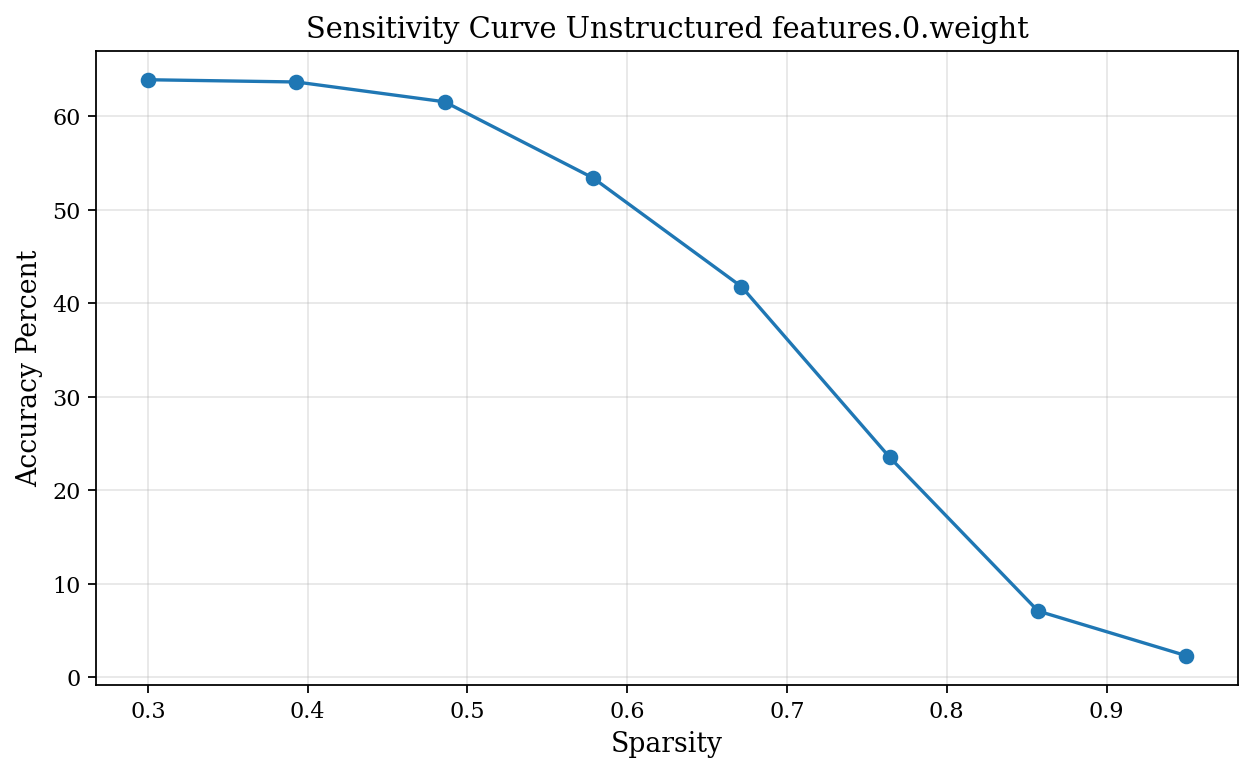

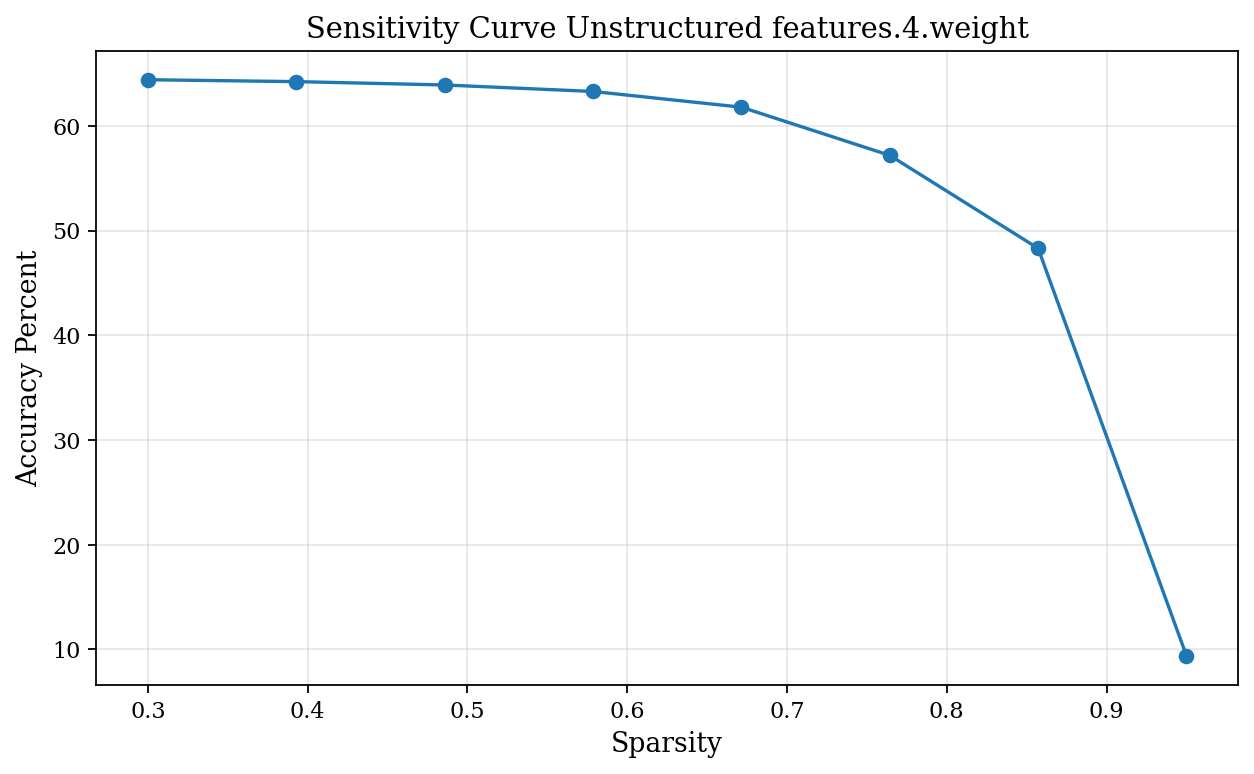

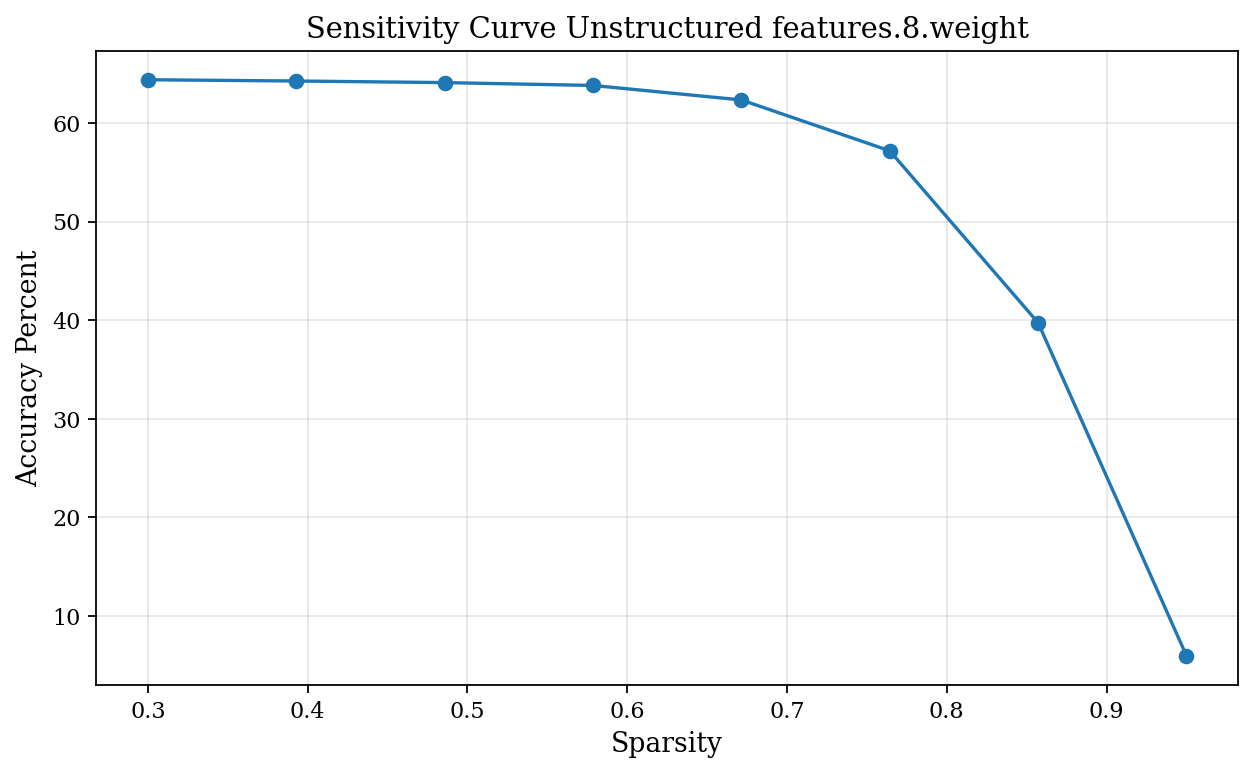

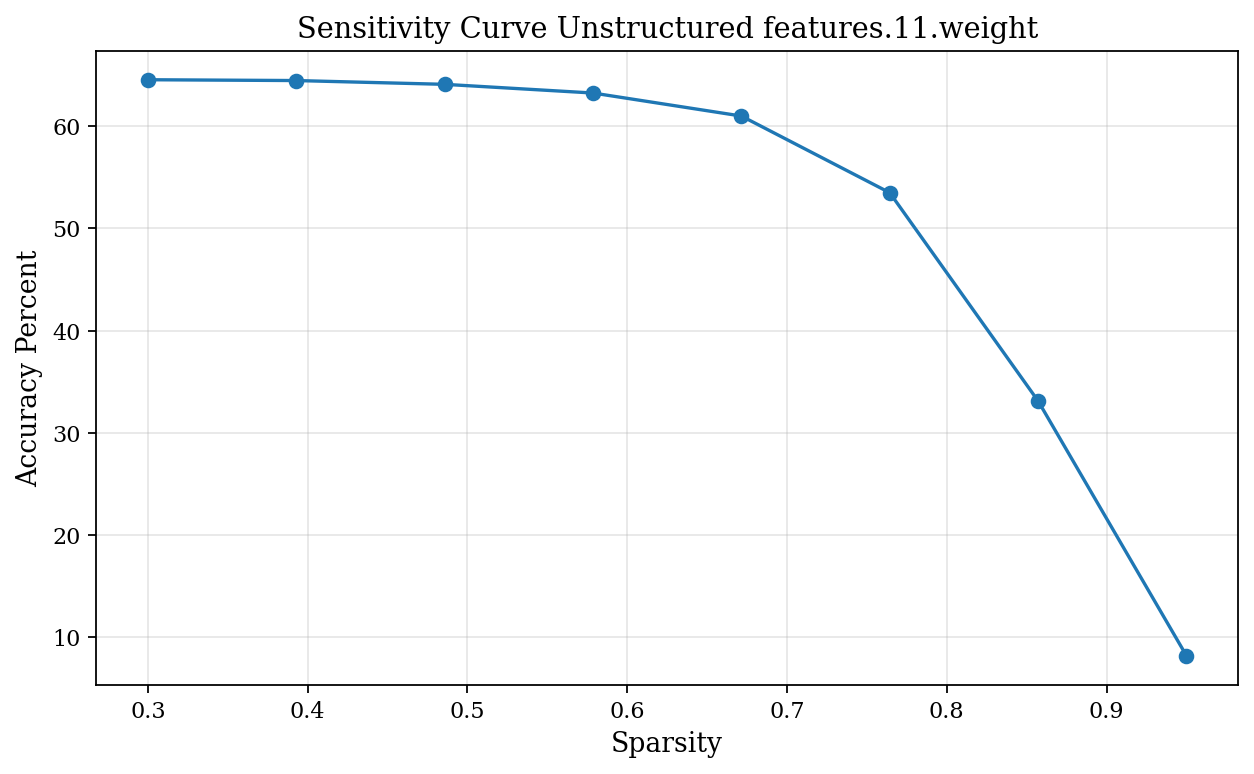

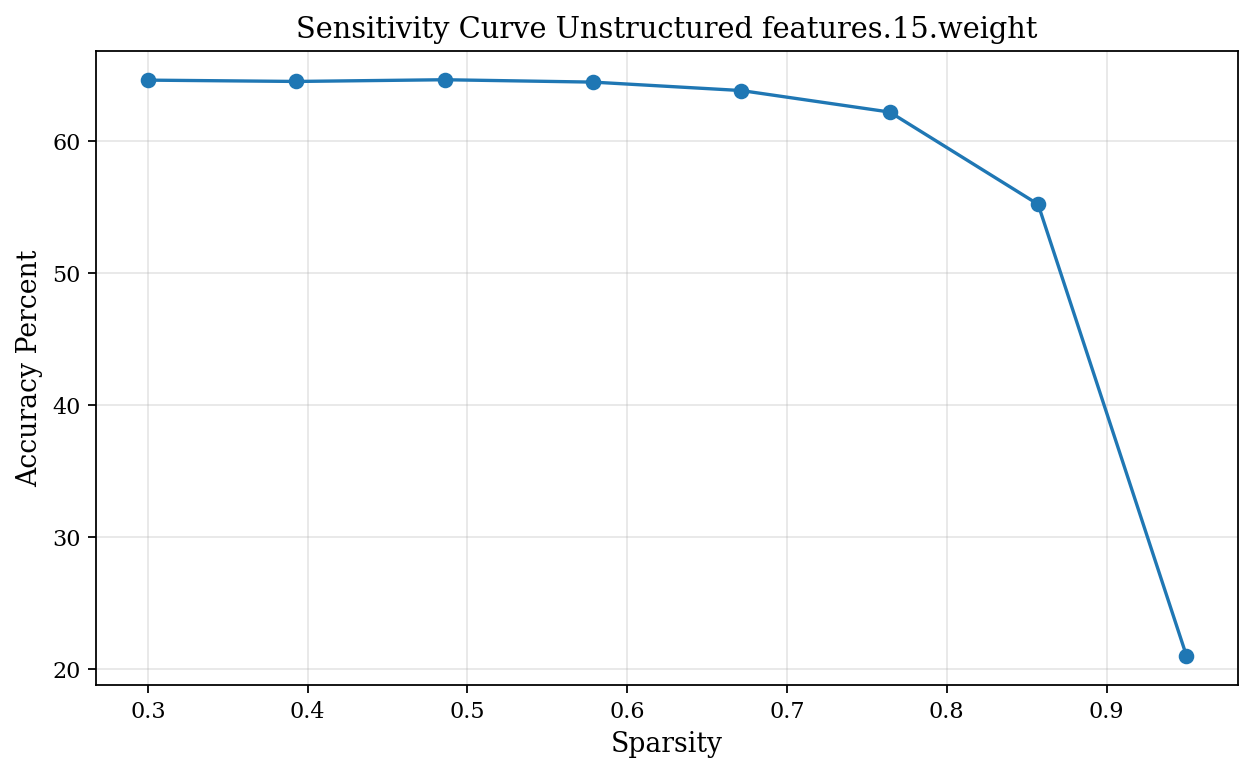

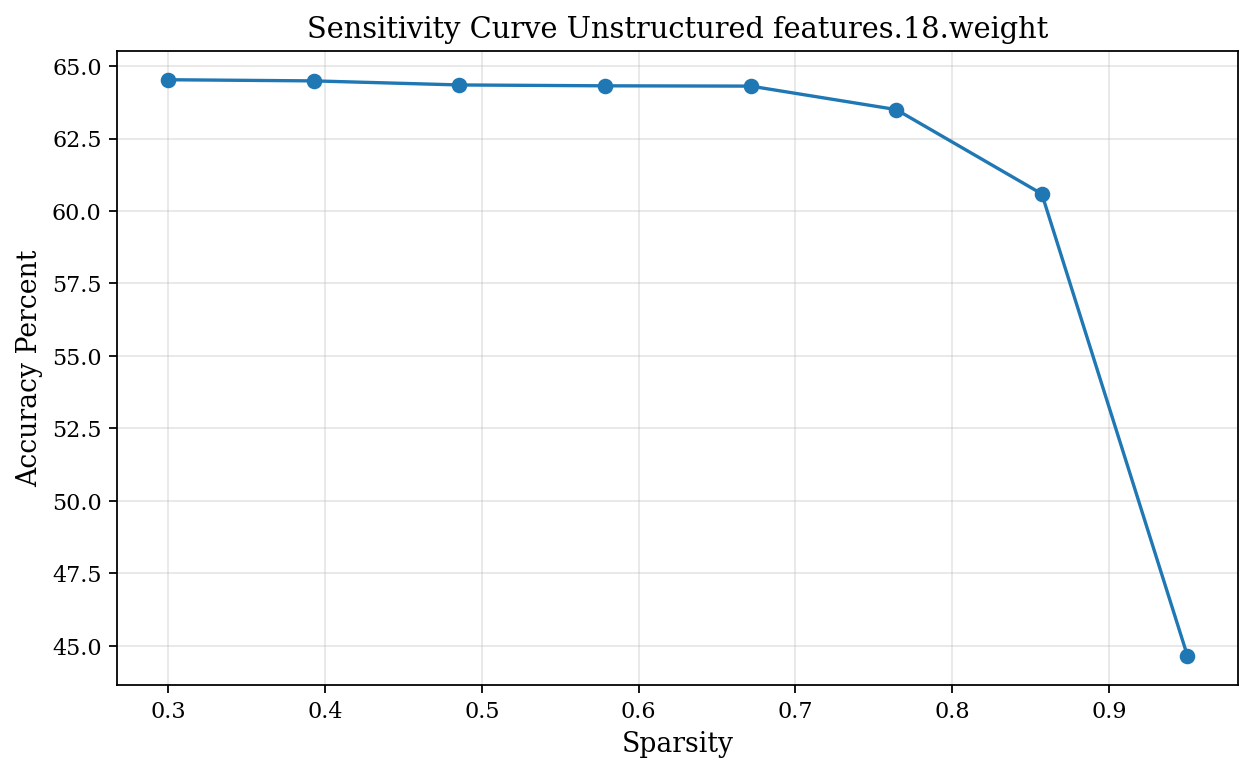

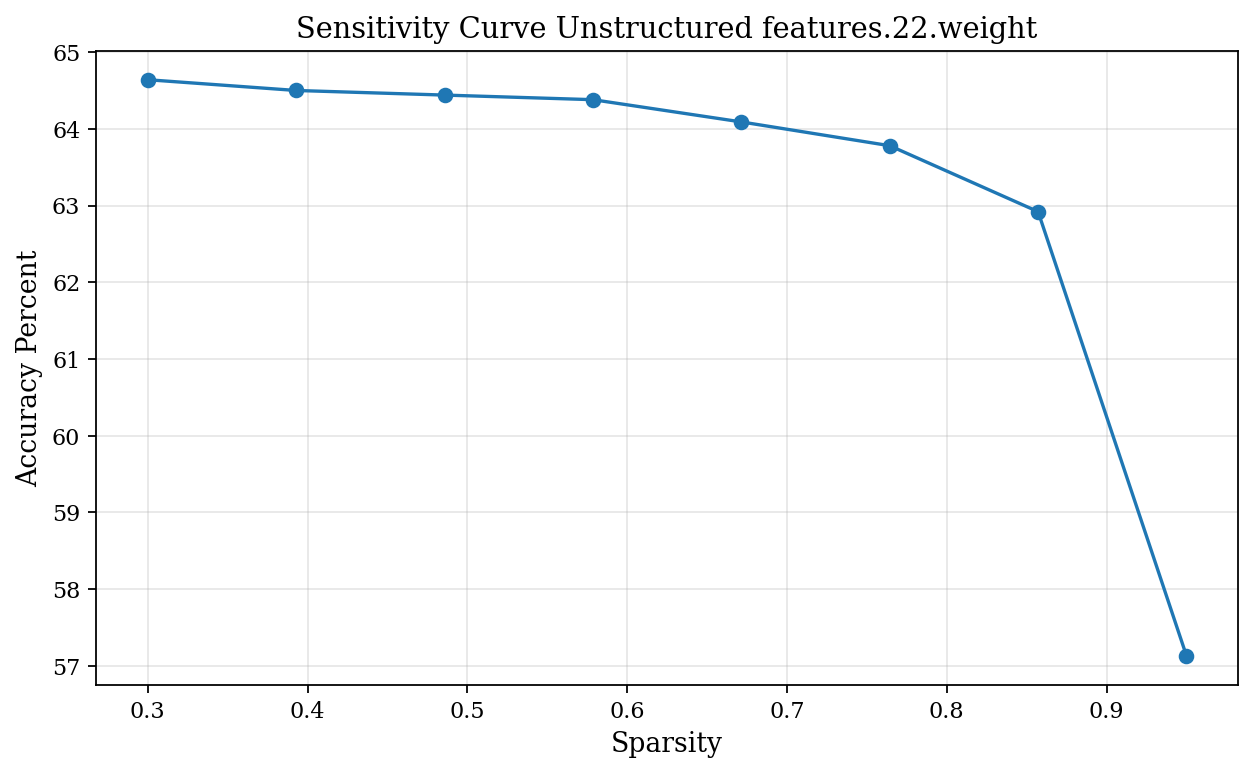

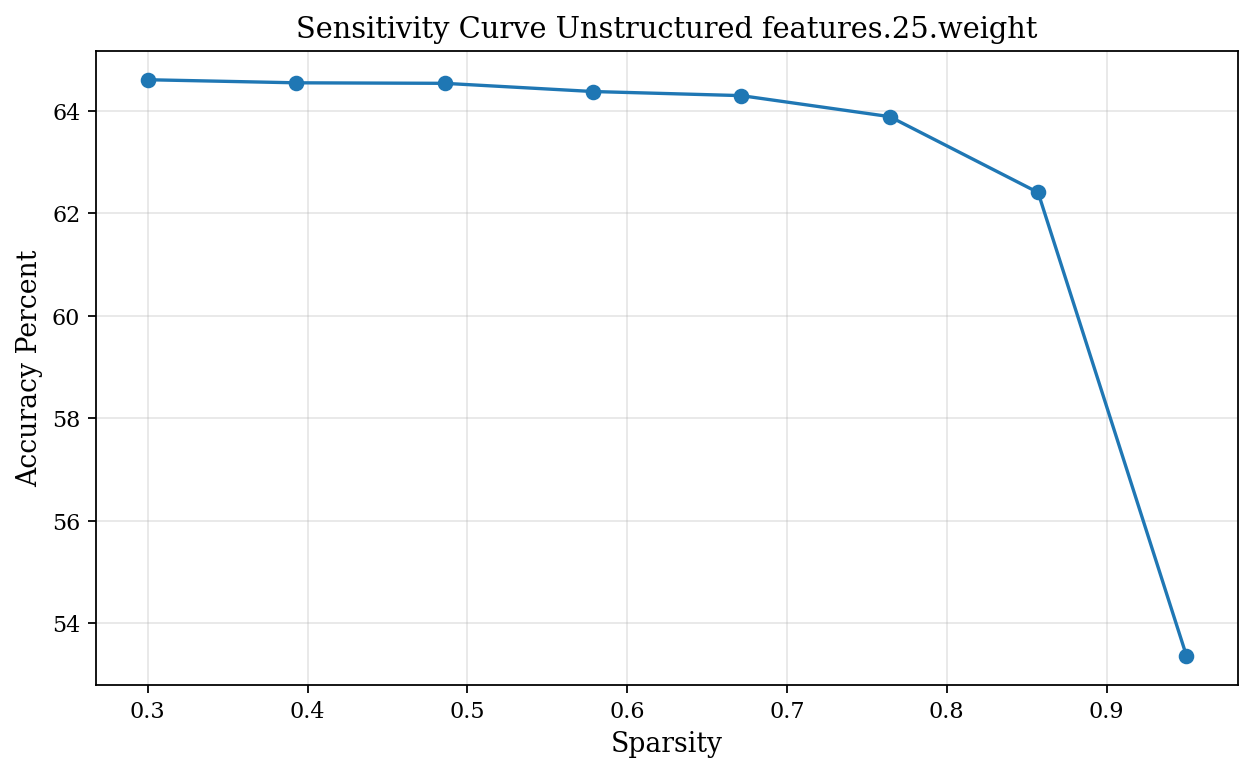

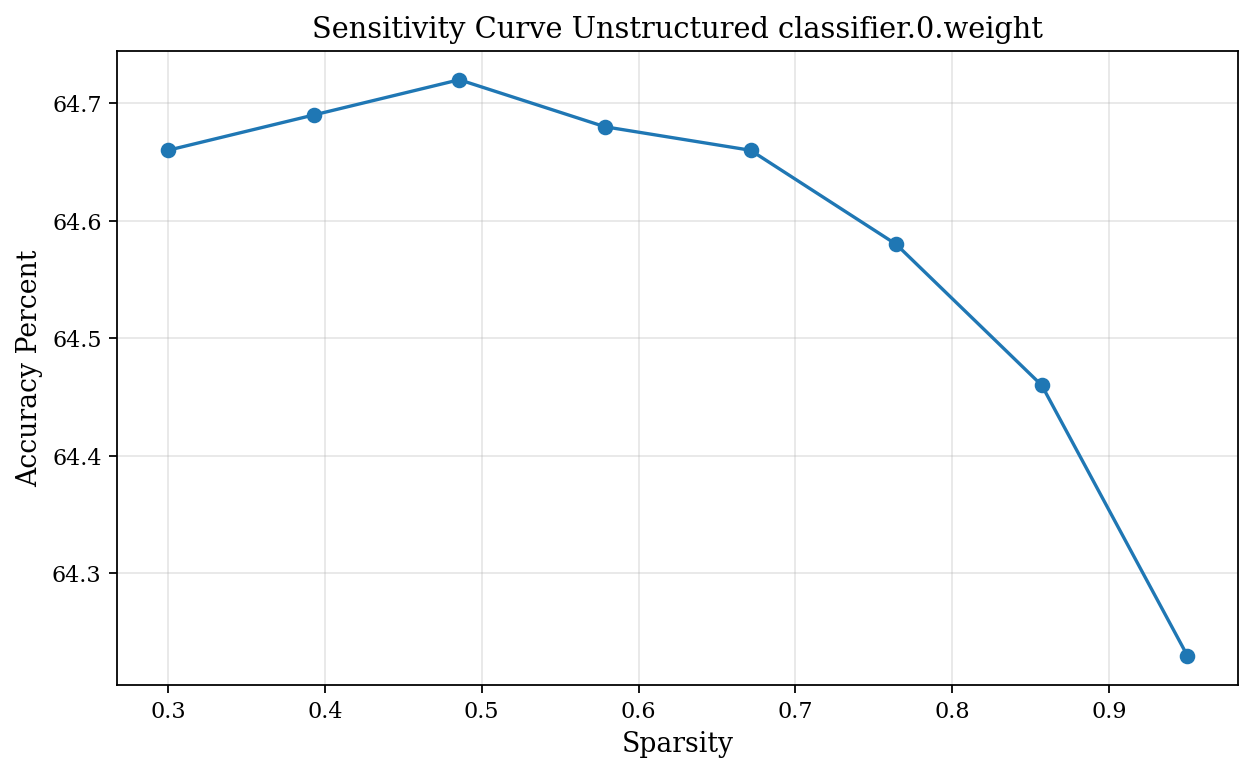

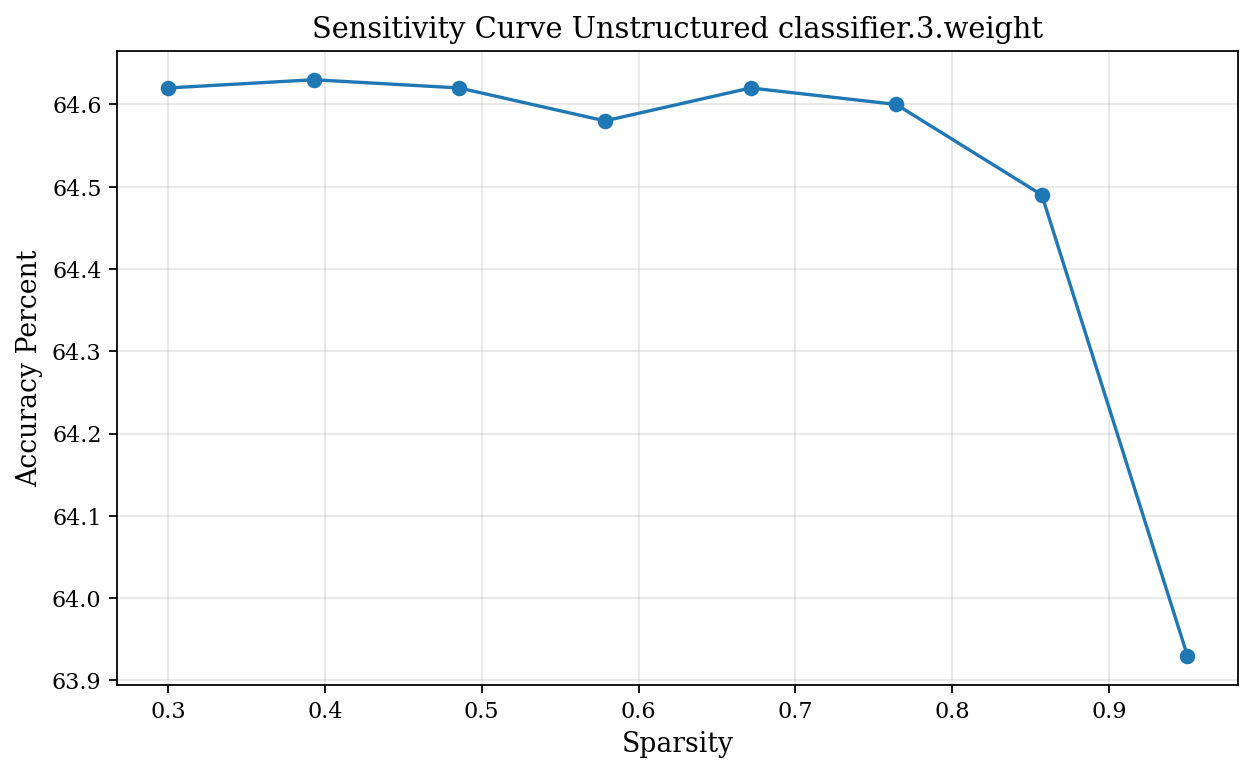

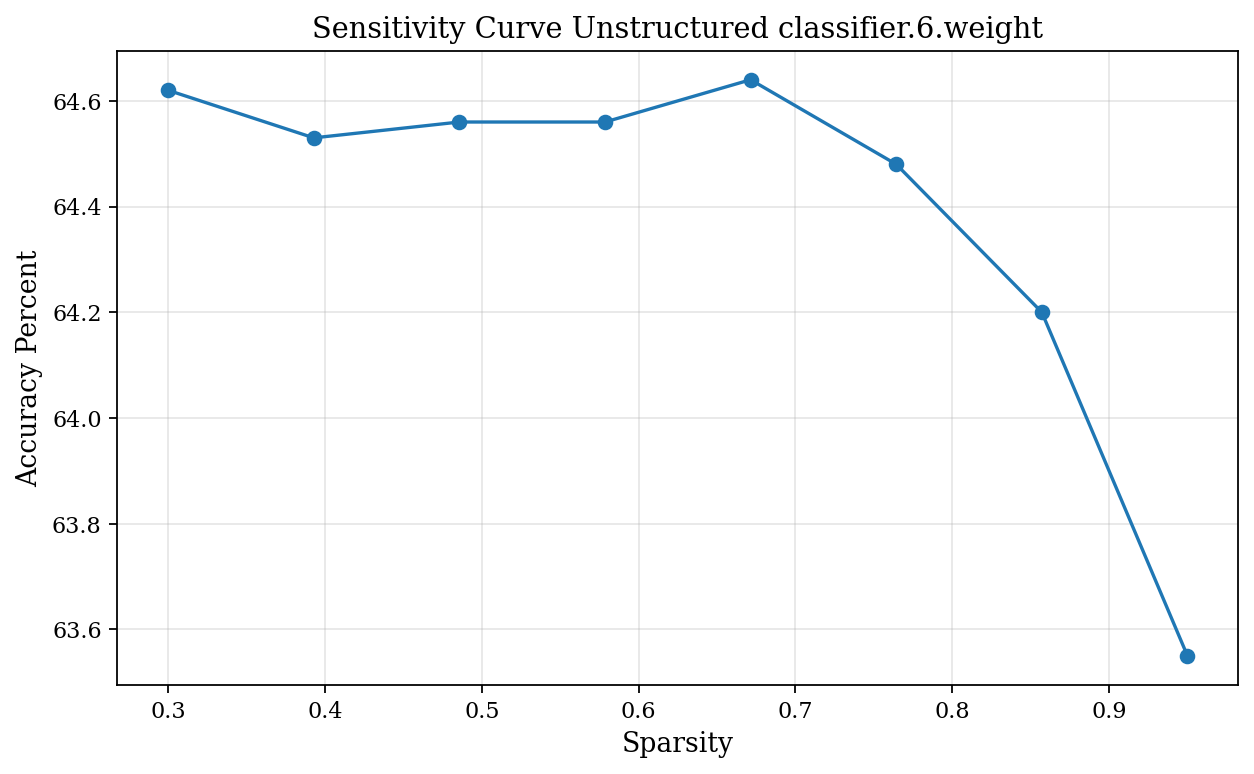

In [9]:
# Cell 08 Unstructured sensitivity scan and plotting

# we prune one weight tensor at a time across a scan of sparsities and measure accuracy
# results are plotted as one figure per layer to avoid clutter
# titles and labels are capitalized

@torch.inference_mode()
def sensitivity_scan_unstructured(model, loader, sparsities=np.linspace(0.3, 0.95, 8)):
    model.eval()
    results = {}
    for name, p in model.named_parameters():
        if p.dim() <= 1:
            continue
        base = p.detach().clone()
        accs = []
        for s in sparsities:
            fine_grained_prune_tensor_(p, float(s))
            acc = evaluate(model, loader, verbose=False)
            accs.append(acc)
            p.copy_(base)
        results[name] = accs
        print(f"scanned {name}")
    return sparsities, results

scan_s, scan_res = sensitivity_scan_unstructured(copy.deepcopy(vgg), test_loader)

# plot one panel per layer as separate figures
for name, accs in scan_res.items():
    plt.figure(figsize=(8, 5))
    plt.plot(scan_s, accs, marker="o")
    plt.title(f"Sensitivity Curve Unstructured {name}")
    plt.xlabel("Sparsity")
    plt.ylabel("Accuracy Percent")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [10]:
# Cell 09 Build per layer sparsity plan for seventy percent overall and apply

# rule assign higher sparsity to layers with more parameters and lower sensitivity
# we use a simple heuristic combine parameter share and slope of accuracy drop
# then scale to reach target overall seventy percent

sizes = layer_param_dict(vgg)
names = list(sizes.keys())

# estimate sensitivity as average loss in accuracy slope across scan
sens = {}
for name in names:
    accs = scan_res[name]
    # larger drop implies higher sensitivity therefore lower target sparsity
    drop = max(0.0, scan_res[name][0] - scan_res[name][-1])
    sens[name] = drop + 1e-6

# normalize factors
size_total = sum(sizes.values())
size_w = {n: sizes[n] / size_total for n in names}
inv_sens = {n: 1.0 / sens[n] for n in names}
inv_sum = sum(inv_sens.values())
inv_sens_w = {n: inv_sens[n] / inv_sum for n in names}

# base sparsity per layer proportional to size weight and inverse sensitivity
base = {n: max(0.30, min(0.95, 0.85 * size_w[n] / max(inv_sens_w[n], 1e-6))) for n in names}

# scale to target overall
target_overall = 0.70
plan = scale_sparsities_to_target(vgg, base, target=target_overall)

print("proposed sparsity plan and layer sizes")
for n in names:
    print(f"{n:40s} size {sizes[n]:8d} sparsity {plan[n]:.3f}")

print("approx overall from plan", overall_sparsity_from_dict(vgg, plan))

# apply pruning
vgg_unstruct = copy.deepcopy(vgg)
pruner = FineGrainedPruner(vgg_unstruct, plan)
print("after applying masks current model sparsity", model_sparsity(vgg_unstruct))
torch.save(vgg_unstruct.state_dict(), "vgg11_unstructured_70.pt")
print("saved unstructured seventy model to vgg11_unstructured_70.pt")


proposed sparsity plan and layer sizes
features.0.weight                        size     1728 sparsity 0.243
features.4.weight                        size    73728 sparsity 0.243
features.8.weight                        size   294912 sparsity 0.465
features.11.weight                       size   589824 sparsity 0.768
features.15.weight                       size  1179648 sparsity 0.768
features.18.weight                       size  2359296 sparsity 0.768
features.22.weight                       size  2359296 sparsity 0.478
features.25.weight                       size  2359296 sparsity 0.716
classifier.0.weight                      size 102760448 sparsity 0.768
classifier.3.weight                      size 16777216 sparsity 0.313
classifier.6.weight                      size   409600 sparsity 0.243
approx overall from plan 0.7000000046452215
after applying masks current model sparsity 0.6999103664501909
saved unstructured seventy model to vgg11_unstructured_70.pt


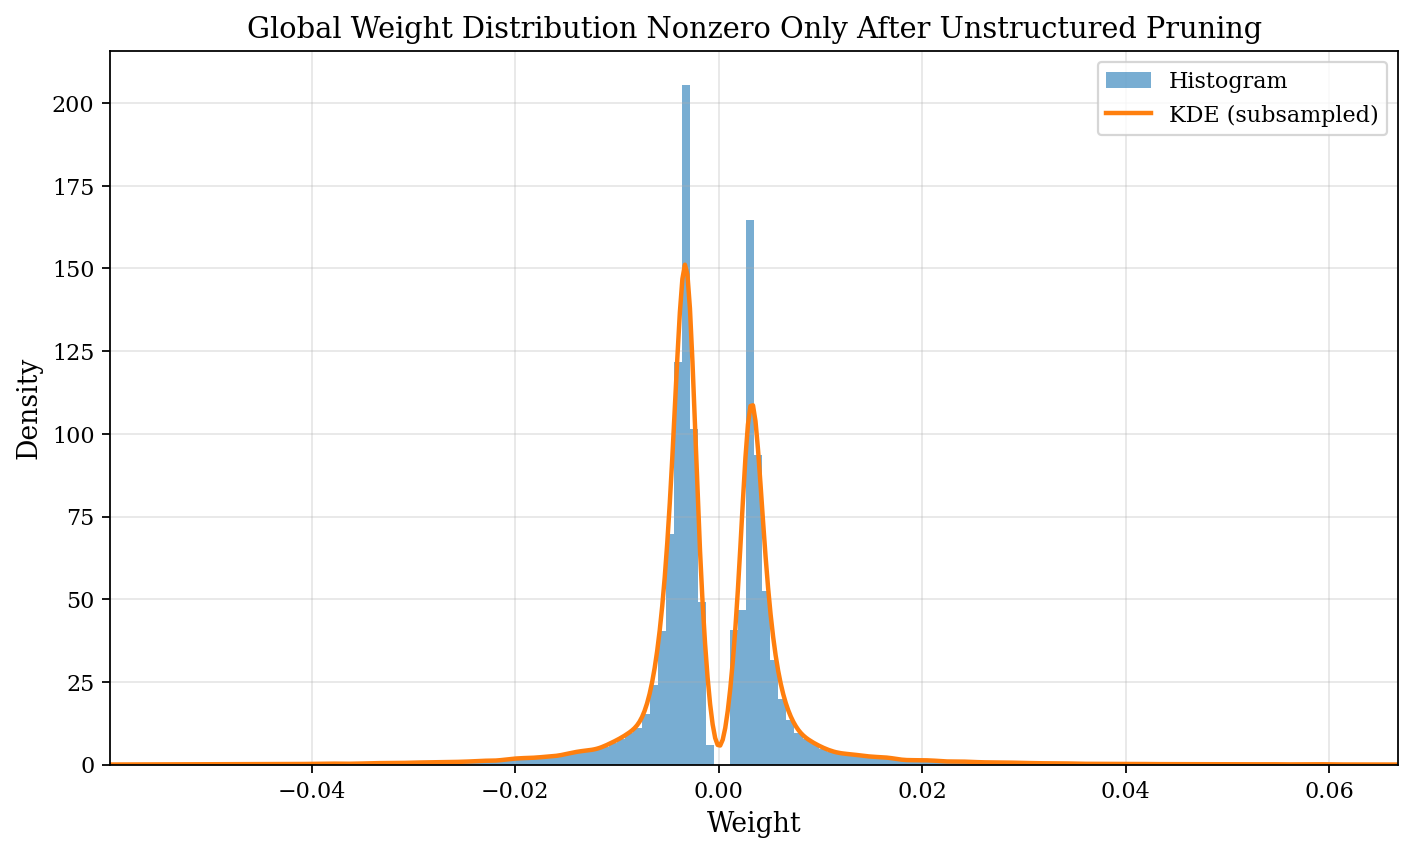

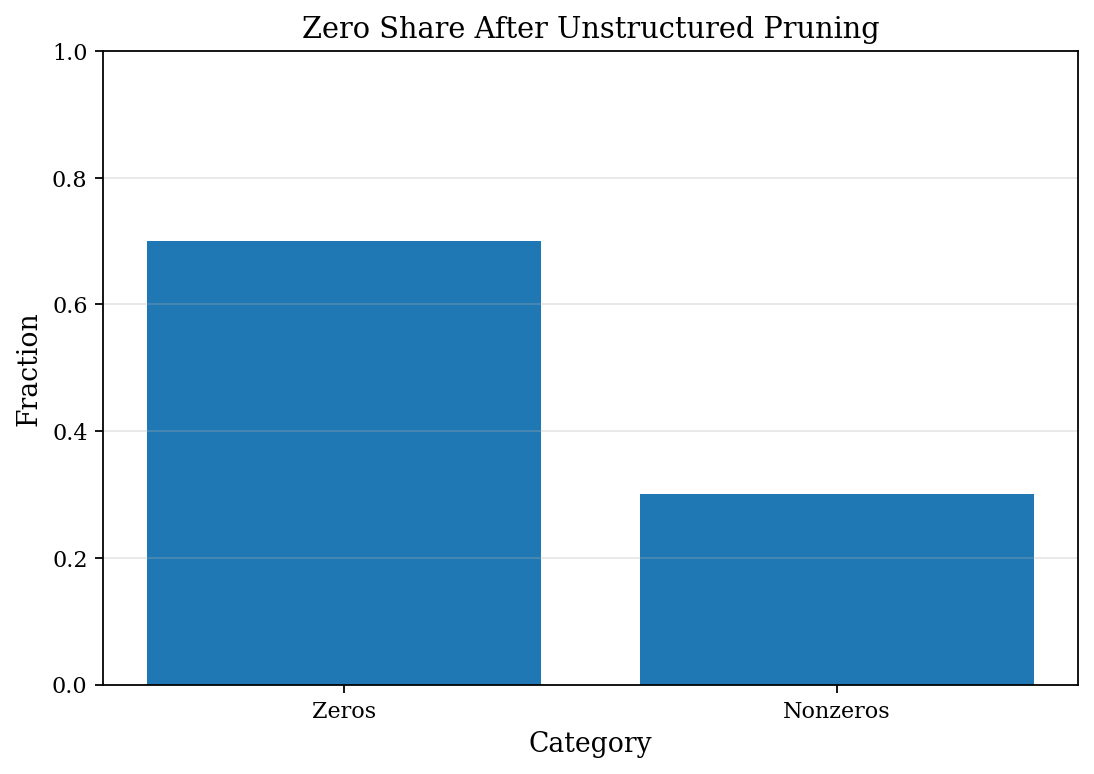

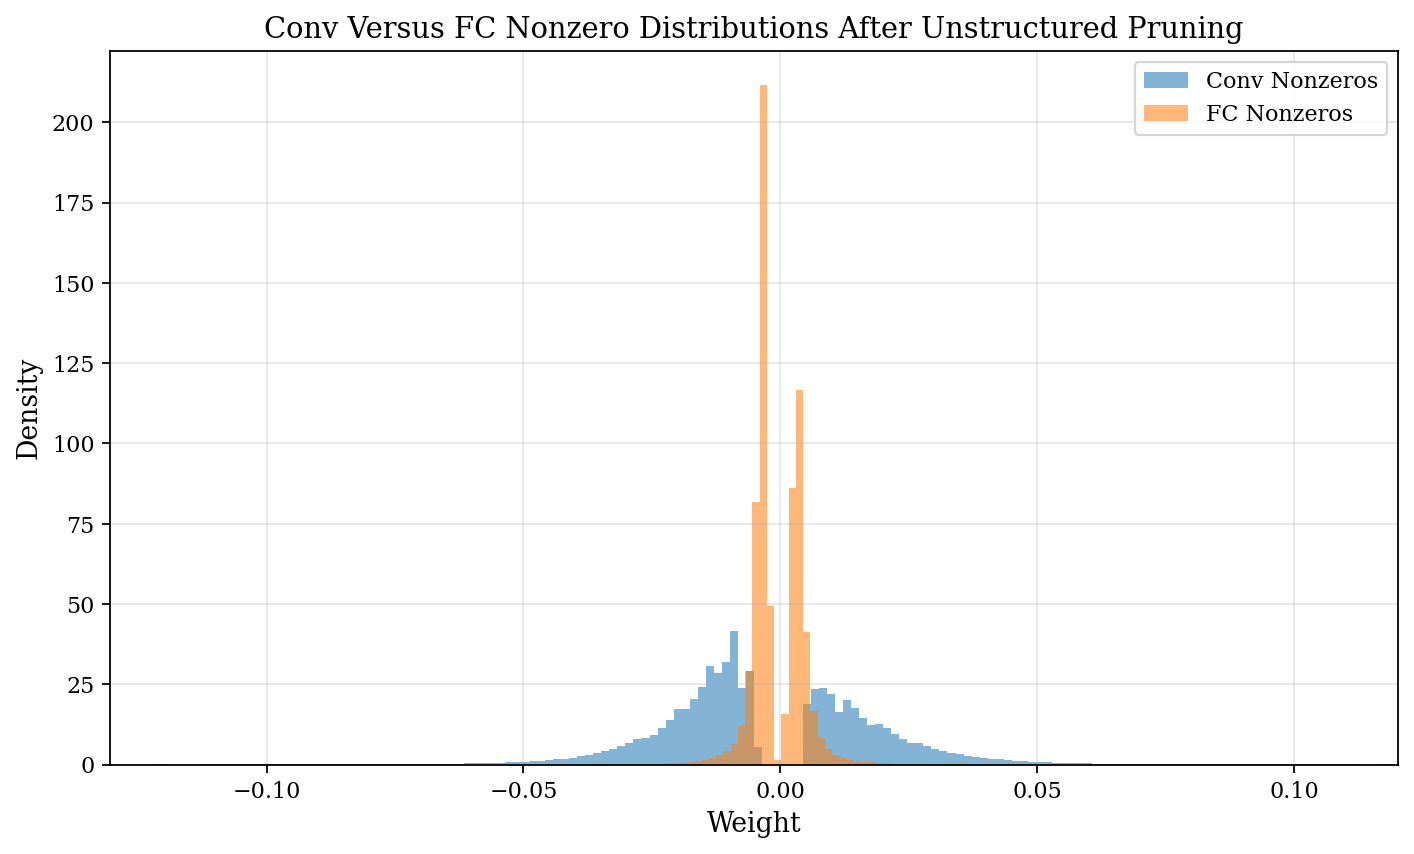

Layer Stats After Unstructured Pruning
Layer                                     Mean       Std      Skew   Kurtosis    Sparsity
features.0.weight                      -0.0036    0.2461    -0.128     +2.936      0.242
features.4.weight                      -0.0066    0.0476    -0.088     +6.383      0.243
features.8.weight                      -0.0023    0.0278    +0.089     +1.911      0.465
features.11.weight                     -0.0015    0.0199    +0.137     +4.079      0.768
features.15.weight                     -0.0003    0.0141    +0.234     +3.827      0.768
features.18.weight                     -0.0001    0.0097    +0.323     +4.328      0.768
features.22.weight                     -0.0005    0.0088    +0.037     +2.900      0.478
features.25.weight                     -0.0015    0.0086    +0.219     +6.965      0.716
classifier.0.weight                    -0.0001    0.0020    +0.014     +3.901      0.768
classifier.3.weight                    -0.0004    0.0051    +0.297    

In [11]:
# Cell 10 Weight distribution AFTER unstructured pruning FAST

# replace your plotting part of Cell 10 with this entire cell
# keep your fine-tune loop in its own cell as you already have

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

def plot_after_unstructured(model, pclip=(0.05, 99.95), add_kde=True):
    # reuse helpers from Cell 06 (assumes they exist in notebook)
    buckets = _collect_weights(model)
    allw, conv, fc = buckets["all"], buckets["conv"], buckets["fc"]
    nz = allw[allw != 0]
    zeros_frac = float((allw == 0).mean())

    # Global nonzero histogram + KDE
    lo, hi = _robust_xlim(nz, pclip[0], pclip[1])
    xs = nz[(nz >= lo) & (nz <= hi)]
    plt.figure(figsize=(9, 5.5))
    plt.hist(xs, bins=_fd_bins(xs), density=True, alpha=0.6, label="Histogram")
    if add_kde:
        grid, dens = _kde_curve(xs, lo, hi)
        if grid is not None:
            plt.plot(grid, dens, linewidth=2, label="KDE (subsampled)")
    plt.title("Global Weight Distribution Nonzero Only After Unstructured Pruning")
    plt.xlabel("Weight"); plt.ylabel("Density")
    plt.xlim(lo, hi); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # Zero share bar
    plt.figure(figsize=(7, 5))
    plt.bar(["Zeros", "Nonzeros"], [zeros_frac, 1 - zeros_frac])
    plt.title("Zero Share After Unstructured Pruning")
    plt.xlabel("Category"); plt.ylabel("Fraction")
    plt.ylim(0, 1); plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

    # Conv vs FC nonzero overlay
    conv_nz = conv[conv != 0] if conv.size else np.array([])
    fc_nz   = fc[fc != 0] if fc.size else np.array([])
    if conv_nz.size and fc_nz.size:
        lo2 = min(_robust_xlim(conv_nz, pclip[0], pclip[1])[0], _robust_xlim(fc_nz, pclip[0], pclip[1])[0])
        hi2 = max(_robust_xlim(conv_nz, pclip[0], pclip[1])[1], _robust_xlim(fc_nz, pclip[0], pclip[1])[1])
    else:
        lo2, hi2 = lo, hi
    plt.figure(figsize=(9, 5.5))
    if conv_nz.size:
        xc = conv_nz[(conv_nz >= lo2) & (conv_nz <= hi2)]
        plt.hist(xc, bins=_fd_bins(xc), density=True, alpha=0.55, label="Conv Nonzeros")
    if fc_nz.size:
        xf = fc_nz[(fc_nz >= lo2) & (fc_nz <= hi2)]
        plt.hist(xf, bins=_fd_bins(xf), density=True, alpha=0.55, label="FC Nonzeros")
    plt.title("Conv Versus FC Nonzero Distributions After Unstructured Pruning")
    plt.xlabel("Weight"); plt.ylabel("Density")
    plt.xlim(lo2, hi2); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # Layer stats
    print("Layer Stats After Unstructured Pruning")
    print("{:<36} {:>9} {:>9} {:>9} {:>10} {:>11}".format(
        "Layer", "Mean", "Std", "Skew", "Kurtosis", "Sparsity"))
    for name, arr in buckets["layers"].items():
        mean = float(arr.mean()); std = float(arr.std())
        skew = float(st.skew(arr, bias=False)); kurt = float(st.kurtosis(arr, bias=False))
        spars = float((arr == 0).mean())
        print("{:<36} {:>+9.4f} {:>9.4f} {:>+9.3f} {:>+10.3f} {:>10.3f}".format(
            name, mean, std, skew, kurt, spars))

# Run after you’ve created vgg_unstruct
plot_after_unstructured(vgg_unstruct, pclip=(0.05, 99.95), add_kde=True)


In [12]:
#Cell 11 Structured channel pruning utilities

# we prune output channels in a conv layer and corresponding input channels in the next conv
# wealso prune batch norm tensors tied to channel count
#ranking uses frobenius norm of channel filters magnitude

def channel_importance_out_filters(weight: torch.Tensor):
    # weight shape out in k k
    # importance per out channel is frobenius norm over in and spatial dims
    out = weight.shape[0]
    view = weight.detach().float().view(out, -1)
    imp = torch.norm(view, p=2, dim=1)
    return imp  # shape out

@torch.no_grad()
def structured_prune_model(model: nn.Module, per_layer_prune_ratio: dict):
    m = copy.deepcopy(model)
    feats = [mod for mod in m.features if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.BatchNorm2d) or isinstance(mod, nn.ReLU) or isinstance(mod, nn.MaxPool2d)]
    # collect conv and bn in order
    convs = [mod for mod in m.features if isinstance(mod, nn.Conv2d)]
    bns   = [mod for mod in m.features if isinstance(mod, nn.BatchNorm2d)]
    # map conv index to bn index by order assumption conv followed by bn
    # torchvion vgg places conv bn relu seq
    bn_idx = 0
    conv_to_bn = {}
    for i, layer in enumerate(m.features):
        if isinstance(layer, nn.Conv2d):
            # next bn in sequence
            while bn_idx < len(bns) and not isinstance(m.features[i+1], nn.BatchNorm2d):
                pass
        # build mapping by simple scan
    # simpler method find pairs by walking features
    conv_list = []
    bn_list = []
    for layer in m.features:
        if isinstance(layer, nn.Conv2d):
            conv_list.append(layer)
        if isinstance(layer, nn.BatchNorm2d):
            bn_list.append(layer)
    # apply pruning per conv except last which feeds classifier
    for i in range(len(conv_list)-1):
        conv = conv_list[i]
        bn   = bn_list[i]
        next_conv = conv_list[i+1]
        ratio = per_layer_prune_ratio.get(i, 0.0)
        ratio = float(max(0.0, min(0.95, ratio)))
        if ratio <= 0.0:
            continue
        W = conv.weight.detach()
        imp = channel_importance_out_filters(W)
        keep = int(round((1.0 - ratio) * W.shape[0]))
        keep = max(1, keep)
        idx = torch.argsort(imp, descending=True)[:keep]
        # prune current conv out channels
        conv.weight = nn.Parameter(W[idx].clone(), requires_grad=True)
        if conv.bias is not None:
            conv.bias = nn.Parameter(conv.bias.detach()[idx].clone(), requires_grad=True)
        # prune bn channels to match
        bn.weight = nn.Parameter(bn.weight.detach()[idx].clone(), requires_grad=True)
        bn.bias   = nn.Parameter(bn.bias.detach()[idx].clone(), requires_grad=True)
        bn.running_mean = bn.running_mean.detach()[idx].clone()
        bn.running_var  = bn.running_var.detach()[idx].clone()
        bn.num_features = keep
        # prune next conv input channels to match
        Wn = next_conv.weight.detach()
        next_conv.weight = nn.Parameter(Wn[:, idx, :, :].clone(), requires_grad=True)
        next_conv.in_channels = keep
        conv.out_channels = keep
    return m

def conv_param_counts(model):
    counts = []
    names = []
    for i, mod in enumerate([m for m in model.features if isinstance(m, nn.Conv2d)]):
        names.append(f"conv{i}")
        counts.append(mod.weight.numel())
    return names, counts

print("structured pruning utils ready")


structured pruning utils ready


In [13]:
# ===== Cell 11b (NEW): Structured surgery helpers to hit ~70% memory =====
import torch
import torch.nn as nn
import math
from copy import deepcopy

def _find_last_conv_and_bn_indices(vgg_features: nn.Sequential):
    last_conv_idx, last_bn_idx = None, None
    for i, m in enumerate(vgg_features):
        if isinstance(m, nn.Conv2d):
            last_conv_idx = i
        if isinstance(m, nn.BatchNorm2d):
            last_bn_idx = i
    assert last_conv_idx is not None, "No Conv2d found in model.features"
    # BN might be None if a non-BN variant is used
    return last_conv_idx, last_bn_idx

def _l2_rank_out_channels(W: torch.Tensor):
    # W: [Co, Ci, kH, kW] -> L2 score per out-channel
    view = W.detach().float().view(W.shape[0], -1)
    return torch.norm(view, p=2, dim=1)

def _pick_topk_idx_by_score(scores: torch.Tensor, keep_ratio: float):
    k = max(1, int(math.floor(scores.numel() * float(keep_ratio))))
    return scores.topk(k, largest=True).indices.sort()[0]

def _slice_linear_cols(linear: nn.Linear, keep_cols: torch.Tensor):
    W = linear.weight.data[:, keep_cols]
    linear.weight = nn.Parameter(W)
    linear.in_features = W.shape[1]
    if linear.bias is not None:
        linear.bias = nn.Parameter(linear.bias.data)

def _slice_linear_rows(linear: nn.Linear, keep_rows: torch.Tensor):
    W = linear.weight.data[keep_rows, :]
    linear.weight = nn.Parameter(W)
    linear.out_features = W.shape[0]
    if linear.bias is not None:
        linear.bias = nn.Parameter(linear.bias.data[keep_rows])

def prune_lastconv_and_classifier(model_in: nn.Module, lastconv_keep: float, fc2_keep: float) -> nn.Module:
    """
    Structured slice:
      1) prune last conv output channels by L2 score (keep fraction lastconv_keep)
      2) prune matching BN channels
      3) slice classifier[0] columns to keep the selected conv channels (per-channel 7x7 blocks)
      4) prune classifier[3] rows (keep fraction fc2_keep) by L2 row score
      5) slice classifier[6] columns to match pruned classifier[3] rows
    """
    m = deepcopy(model_in).cpu()

    assert hasattr(m, "features") and hasattr(m, "classifier"), "Expected VGG-like model"
    last_conv_idx, last_bn_idx = _find_last_conv_and_bn_indices(m.features)
    last_conv: nn.Conv2d = m.features[last_conv_idx]

    # 1) prune last conv out-channels
    scores = _l2_rank_out_channels(last_conv.weight)
    keep_out = _pick_topk_idx_by_score(scores, lastconv_keep)

    last_conv.weight = nn.Parameter(last_conv.weight.data[keep_out, :, :, :])
    if last_conv.bias is not None:
        last_conv.bias = nn.Parameter(last_conv.bias.data[keep_out])
    last_conv.out_channels = keep_out.numel()

    # 2) slice BN next to last conv if present
    if last_bn_idx is not None and last_bn_idx > last_conv_idx:
        bn = m.features[last_bn_idx]
        if isinstance(bn, nn.BatchNorm2d):
            bn.weight = nn.Parameter(bn.weight.data[keep_out])
            bn.bias   = nn.Parameter(bn.bias.data[keep_out])
            bn.running_mean = bn.running_mean[keep_out]
            bn.running_var  = bn.running_var[keep_out]
            bn.num_features = keep_out.numel()

    # 3) slice classifier[0] columns per kept channel (block of 7x7 per channel)
    #    torchvision VGG uses AdaptiveAvgPool2d((7,7)) before classifier -> per-channel 49 columns are contiguous
    fc0: nn.Linear = m.classifier[0]
    Co = scores.numel()                     # original last-conv out-channels before slicing
    spatial = fc0.in_features // Co         # should be 49
    assert spatial * Co == fc0.in_features, "Unexpected classifier[0].in_features; check the model topology."

    blocks = []
    for ch in keep_out.tolist():
        start = ch * spatial
        stop  = start + spatial
        blocks.append(torch.arange(start, stop))
    keep_cols_fc0 = torch.cat(blocks)
    _slice_linear_cols(fc0, keep_cols_fc0)

    # 4) prune classifier[3] rows by L2 row score and 5) slice classifier[6] columns accordingly
    fc1: nn.Linear = m.classifier[3]
    fc2: nn.Linear = m.classifier[6]  # final classifier to 100 classes

    row_scores = fc1.weight.data.flatten(1).norm(p=2, dim=1)
    keep_rows_fc1 = _pick_topk_idx_by_score(row_scores, fc2_keep)

    _slice_linear_rows(fc1, keep_rows_fc1)
    _slice_linear_cols(fc2, keep_rows_fc1)

    return m

def bits_fp32_params(model: nn.Module) -> int:
    return 32 * sum(p.numel() for p in model.parameters())


uniform ratio 0.1 acc 56.79
uniform ratio 0.2 acc 35.05
uniform ratio 0.3 acc 13.79
uniform ratio 0.4 acc 7.48
uniform ratio 0.5 acc 1.77


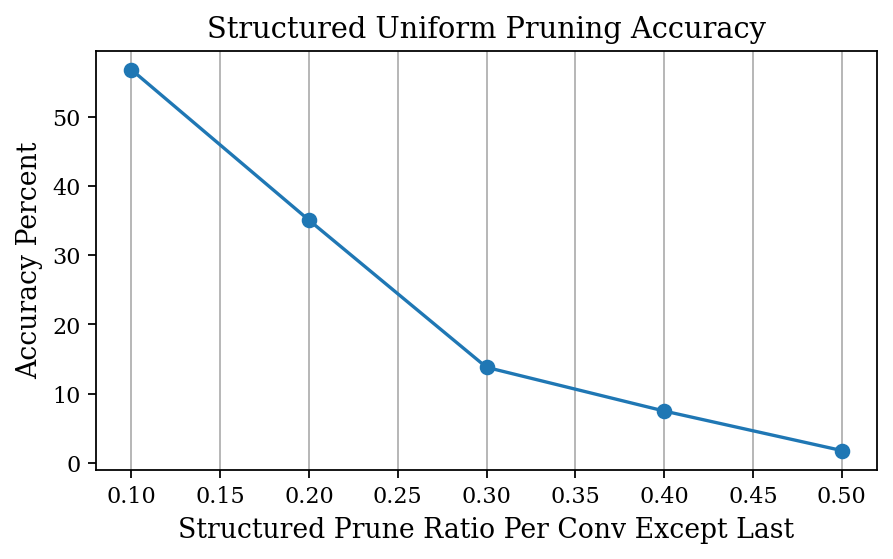

per layer ratios for structured pruning (pre-classifier surgery)
conv0 ratio 0.500
conv1 ratio 0.504
conv2 ratio 0.516
conv3 ratio 0.532
conv4 ratio 0.564
conv5 ratio 0.628
conv6 ratio 0.628
accuracy 1.58 percent
bits dense 4133809280 bits structured (conv-only) 3904183808
saved conv-only structured model to vgg11_structured_conv_only.pt
[structured-70] bits fraction ≈ 0.703 with lastconv_keep=0.70, fc2_keep=1.00
saved 70% memory structured model to vgg11_structured_70pct_bits.pt


In [14]:
# ===== Cell 12 (REPLACE): Structured plan + co-prune last conv and classifier to ~70% bits =====
from copy import deepcopy

# 12A) Uniform scan (unchanged logic)
uniform_scan = [0.10, 0.20, 0.30, 0.40, 0.50]
acc_uniform = []
for r in uniform_scan:
    ratios = {i: r for i in range(len([m for m in vgg.features if isinstance(m, nn.Conv2d)]) - 1)}
    m_pr = structured_prune_model(vgg, ratios).to(DEVICE)
    a = evaluate(m_pr, test_loader, verbose=False)
    acc_uniform.append(a)
    print("uniform ratio", r, "acc", f"{a:.2f}")

fig = fig_two_col()
plt.plot(uniform_scan, acc_uniform, marker="o")
plt.xlabel("Structured Prune Ratio Per Conv Except Last")
plt.ylabel("Accuracy Percent")
plt.title("Structured Uniform Pruning Accuracy")
plt.grid(axis="x")
plt.show()

# 12B) Build per-layer conv ratios as before (do not prune last conv here)
names, counts = conv_param_counts(vgg)
total_conv_params = sum(counts)
share = [c / total_conv_params for c in counts]
raw = {i: min(0.90, 0.50 + 0.50 * share[i]) for i in range(len(share)-1)}  # exclude last conv

def bits_after_struct(model, ratios):
    pruned = structured_prune_model(model, ratios)
    return model_bits(pruned, count_nonzero_only=False), pruned

base_bits = model_bits(vgg, count_nonzero_only=False)
lo, hi = 0.6, 1.2
target_bits_for_conv_only = base_bits * 0.30  # initial internal target; classifier dominates anyway
best = raw.copy()
best_model_conv_only = None
for _ in range(20):
    mid = 0.5 * (lo + hi)
    trial = {i: max(0.0, min(0.95, raw[i] * mid)) for i in raw}
    b, pruned_tmp = bits_after_struct(vgg, trial)
    if b > target_bits_for_conv_only:
        lo = mid
    else:
        best = trial
        best_model_conv_only = pruned_tmp
        hi = mid

print("per layer ratios for structured pruning (pre-classifier surgery)")
for i in range(len(best)):
    print(f"conv{i} ratio {best[i]:.3f}")

# Apply the conv-only plan to produce the base structured model (your old vgg_struct)
if best_model_conv_only is None:
    vgg_struct = structured_prune_model(vgg, best).to(DEVICE)
else:
    vgg_struct = best_model_conv_only.to(DEVICE)

acc_struct_before_ft = evaluate(vgg_struct, test_loader)
print("bits dense", base_bits, "bits structured (conv-only)", model_bits(vgg_struct))
torch.save(vgg_struct.state_dict(), "vgg11_structured_conv_only.pt")
print("saved conv-only structured model to vgg11_structured_conv_only.pt")

# 12C) NEW: co-prune last conv + classifier to reach ~70% bits
TARGET_BITS_FRAC = 0.70
lastconv_keep_grid = [0.50, 0.60, 0.70, 0.80, 0.90]
fc2_keep_grid      = [0.60, 0.70, 0.80, 0.90, 1.00]

dense_bits = bits_fp32_params(vgg)

best_err, best_frac = 1e9, None
best_model_full = None
best_cfg = None

# search directly on the conv-pruned model (vgg_struct on CPU)
base_struct_cpu = deepcopy(vgg_struct).cpu()

for kc in lastconv_keep_grid:
    for k2 in fc2_keep_grid:
        cand = prune_lastconv_and_classifier(base_struct_cpu, lastconv_keep=kc, fc2_keep=k2)
        frac = bits_fp32_params(cand) / dense_bits
        err = abs(frac - TARGET_BITS_FRAC)
        if err < best_err:
            best_err, best_frac = err, frac
            best_model_full = cand
            best_cfg = (kc, k2)

assert best_model_full is not None, "search failed to find a candidate"
vgg_struct70 = deepcopy(best_model_full).to(DEVICE)
print(f"[structured-70] bits fraction ≈ {best_frac:.3f} with lastconv_keep={best_cfg[0]:.2f}, fc2_keep={best_cfg[1]:.2f}")

# Save the ~70% bits model
torch.save(vgg_struct70.state_dict(), "vgg11_structured_70pct_bits.pt")
print("saved 70% memory structured model to vgg11_structured_70pct_bits.pt")


In [15]:
# ===== Cell 13 (REPLACE): Fine-tune the ~70% memory structured model and adopt it =====
FT2 = 5
opt2 = SGD(vgg_struct70.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
sch2 = CosineAnnealingLR(opt2, FT2)
print("fine tuning structured-70 model")
best_s_acc = 0.0
best_s_state = None
for ep in range(1, FT2+1):
    loss = train_one_epoch(vgg_struct70, train_loader, opt2, sch2)
    acc = evaluate(vgg_struct70, test_loader, verbose=False)
    if acc > best_s_acc:
        best_s_acc = acc
        best_s_state = copy.deepcopy(vgg_struct70.state_dict())
    print(f"epoch {ep} loss {loss:.3f} acc {acc:.2f}")
if best_s_state is not None:
    vgg_struct70.load_state_dict(best_s_state)

acc_struct70 = evaluate(vgg_struct70, test_loader)
print(f"structured-70 accuracy {acc_struct70:.2f} percent")

# adopt this as the "structured" model for downstream cells
vgg_struct = vgg_struct70
torch.save(vgg_struct.state_dict(), "vgg11_structured_FINAL_70pct_bits.pt")
print("adopted structured-70 as vgg_struct")


fine tuning structured-70 model
epoch 1 loss 1.877 acc 54.64
epoch 2 loss 1.523 acc 56.51
epoch 3 loss 1.371 acc 57.74
epoch 4 loss 1.257 acc 60.10
epoch 5 loss 1.174 acc 61.46
accuracy 61.46 percent
structured-70 accuracy 61.46 percent
adopted structured-70 as vgg_struct


In [16]:
# Patch cell for grad cam dependency with a clean fallback
# this cell must run before the grad cam cell

# try import first
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    _USING_EXTERNAL_CAM = True
    print("pytorch grad cam available")
except Exception as _e:
    # attempt install
    import sys, subprocess
    print("installing pytorch grad cam")
    subprocess.run([sys.executable, "-m", "pip", "install", "pytorch-grad-cam", "--quiet"], check=False)
    try:
        from pytorch_grad_cam import GradCAM
        from pytorch_grad_cam.utils.image import show_cam_on_image
        _USING_EXTERNAL_CAM = True
        print("pytorch grad cam installed")
    except Exception:
        # fallback minimal implementation
        import torch
        import numpy as np
        import matplotlib.pyplot as plt

        class GradCAM:
            # minimal grad cam that matches the call pattern used later
            def __init__(self, model, target_layers, use_cuda=False):
                self.model = model
                self.target_layers = target_layers
                self.use_cuda = use_cuda and torch.cuda.is_available()
                self.activations = []
                self.gradients = []
                # hook the single target layer
                assert len(target_layers) == 1, "one target layer expected"
                self.layer = target_layers[0]
                self.h1 = self.layer.register_forward_hook(self._forward_hook)
                self.h2 = self.layer.register_full_backward_hook(self._backward_hook)

            def _forward_hook(self, module, inp, out):
                self.activations.append(out.detach())

            def _backward_hook(self, module, grad_in, grad_out):
                self.gradients.append(grad_out[0].detach())

            def __del__(self):
                # remove hooks on destruction
                try:
                    self.h1.remove(); self.h2.remove()
                except Exception:
                    pass

            def _compute_cam(self):
                # use last stored activation and gradient
                A = self.activations.pop()   # shape n c h w
                G = self.gradients.pop()     # shape n c h w
                # global average pool gradients over spatial dims
                weights = G.mean(dim=(2,3), keepdim=True)  # n c 1 1
                cam = (weights * A).sum(dim=1, keepdim=True)  # n 1 h w
                cam = torch.relu(cam)
                # normalize each map to zero to one
                n, _, h, w = cam.shape
                cam = cam.view(n, h, w)
                cam_min = cam.view(n, -1).min(dim=1)[0].view(n, 1, 1)
                cam_max = cam.view(n, -1).max(dim=1)[0].view(n, 1, 1)
                cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
                return cam.cpu().numpy()

            def __call__(self, input_tensor):
                # forward and backward wrt top predicted class
                self.model.zero_grad(set_to_none=True)
                out = self.model(input_tensor)
                top_class = out.argmax(dim=1)
                # gather scores and backprop
                scores = out.gather(1, top_class.view(-1,1)).squeeze(1)
                scores.sum().backward()
                return self._compute_cam()

        def show_cam_on_image(img_float_rgb, mask, use_rgb=True, alpha=0.5):
            # img is h w 3 in range zero to one, mask is h w in zero to one
            # produce overlay using matplotlib colormap
            cmap = plt.get_cmap("jet")
            heatmap = cmap(mask)[:, :, :3]  # drop alpha
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
            overlay = (1 - alpha) * img_float_rgb + alpha * heatmap
            overlay = np.clip(overlay, 0, 1)
            return (overlay * 255).astype(np.uint8)

        _USING_EXTERNAL_CAM = False
        print("using minimal built in grad cam fallback")


installing pytorch grad cam
using minimal built in grad cam fallback


In [17]:
# Cell 13a GradCAM dependency install

# install the library needed by Cell 14
# !pip -q install pytorch-grad-cam

# Cell 13b GradCAM fallback if install is not possible

# try:
#     from pytorch_grad_cam import GradCAM
#     from pytorch_grad_cam.utils.image import show_cam_on_image
#     print("pytorch-grad-cam available")
# except Exception:
#     import torch, numpy as np, matplotlib.pyplot as plt

#     class GradCAM:
#         def __init__(self, model, target_layers, use_cuda=False):
#             self.model = model
#             assert len(target_layers) == 1
#             self.layer = target_layers[0]
#             self.activations, self.gradients = [], []
#             self.h1 = self.layer.register_forward_hook(self._fh)
#             self.h2 = self.layer.register_full_backward_hook(self._bh)

#         def _fh(self, m, i, o): self.activations.append(o.detach())
#         def _bh(self, m, gi, go): self.gradients.append(go[0].detach())

#         def __call__(self, input_tensor):
#             self.model.zero_grad(set_to_none=True)
#             out = self.model(input_tensor)
#             top = out.argmax(dim=1)
#             out.gather(1, top.view(-1,1)).sum().backward()
#             A = self.activations.pop()    # n c h w
#             G = self.gradients.pop()      # n c h w
#             w = G.mean(dim=(2,3), keepdim=True)
#             cam = torch.relu((w * A).sum(dim=1))  # n h w
#             n = cam.shape[0]
#             cam_min = cam.view(n,-1).min(1)[0].view(n,1,1)
#             cam_max = cam.view(n,-1).max(1)[0].view(n,1,1)
#             cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
#             return cam.cpu().numpy()

#     def show_cam_on_image(img_float_rgb, mask, use_rgb=True, alpha=0.5):
#         cmap = plt.get_cmap("jet")
#         heat = cmap(mask)[:, :, :3]
#         heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
#         overlay = (1 - alpha) * img_float_rgb + alpha * heat
#         return (np.clip(overlay, 0, 1) * 255).astype(np.uint8)

#     print("using minimal built in grad cam fallback")



import torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn

class GradCAM:
    def __init__(self, model, target_layers, use_cuda=False):
        self.model = model.eval()
        assert len(target_layers) == 1, "pass exactly one target layer"
        self.layer = target_layers[0]
        self.activations, self.gradients = [], []
        self.h_fwd = self.layer.register_forward_hook(self._save_act)
        self.h_bwd = self.layer.register_full_backward_hook(self._save_grad)
        self.use_cuda = use_cuda and torch.cuda.is_available()

    def _save_act(self, module, inp, out):  self.activations.append(out.detach())
    def _save_grad(self, module, grad_in, grad_out): self.gradients.append(grad_out[0].detach())

    def __call__(self, input_tensor):
        self.model.zero_grad(set_to_none=True)
        out = self.model(input_tensor)
        top = out.argmax(dim=1)
        out.gather(1, top.view(-1,1)).sum().backward()
        A = self.activations.pop()       # [N,C,H,W]
        G = self.gradients.pop()         # [N,C,H,W]
        w = G.mean(dim=(2,3), keepdim=True)
        cam = torch.relu((w * A).sum(dim=1))      # [N,H,W]
        N = cam.shape[0]
        cmin = cam.view(N,-1).min(1)[0].view(N,1,1)
        cmax = cam.view(N,-1).max(1)[0].view(N,1,1)
        cam = (cam - cmin) / (cmax - cmin + 1e-8)
        return cam.cpu().numpy()

def show_cam_on_image(img_float_rgb, mask, alpha=0.5):
    cmap = plt.get_cmap("jet")
    heat = cmap(mask)[:, :, :3]
    overlay = (1 - alpha) * img_float_rgb + alpha * heat
    return (np.clip(overlay, 0, 1) * 255).astype(np.uint8)



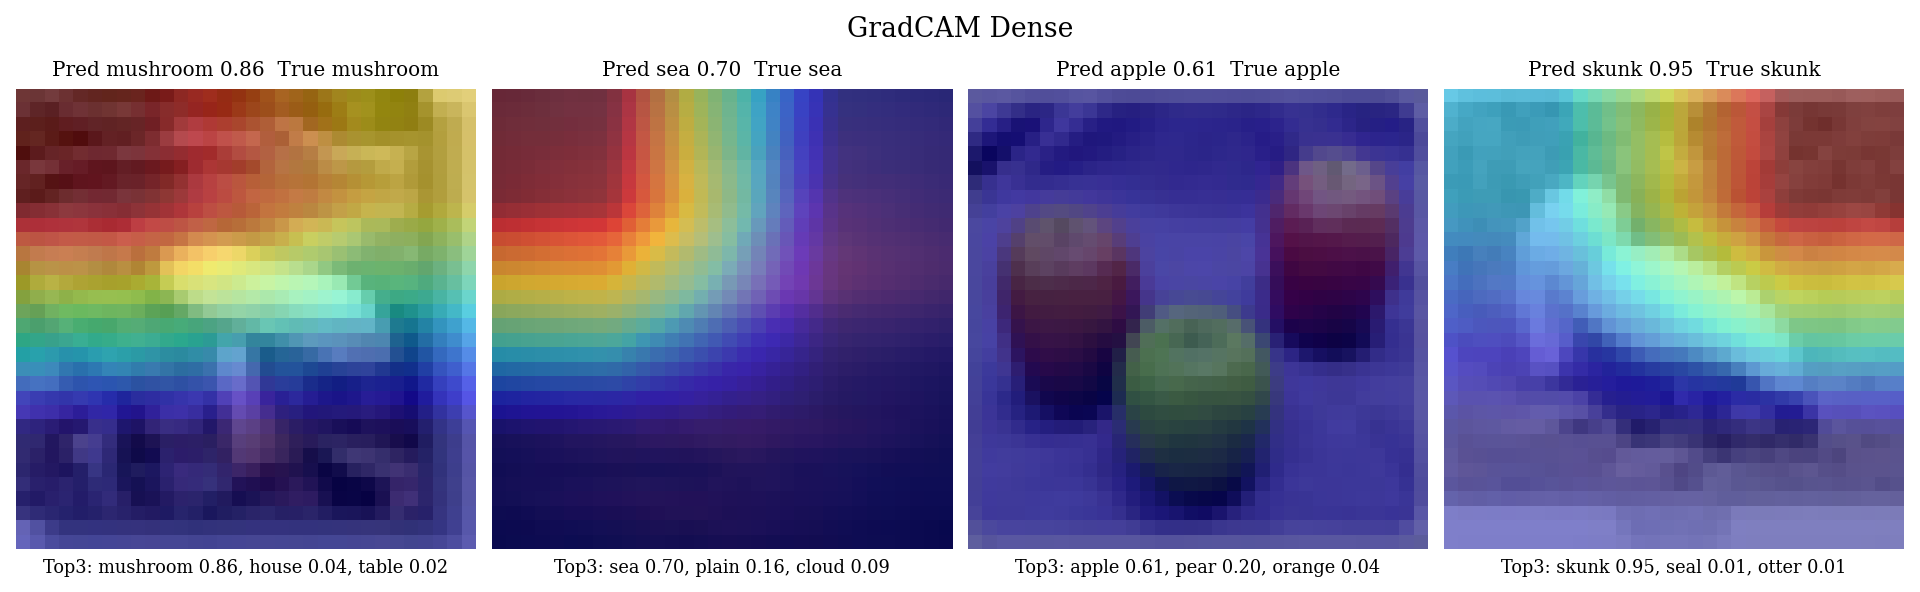

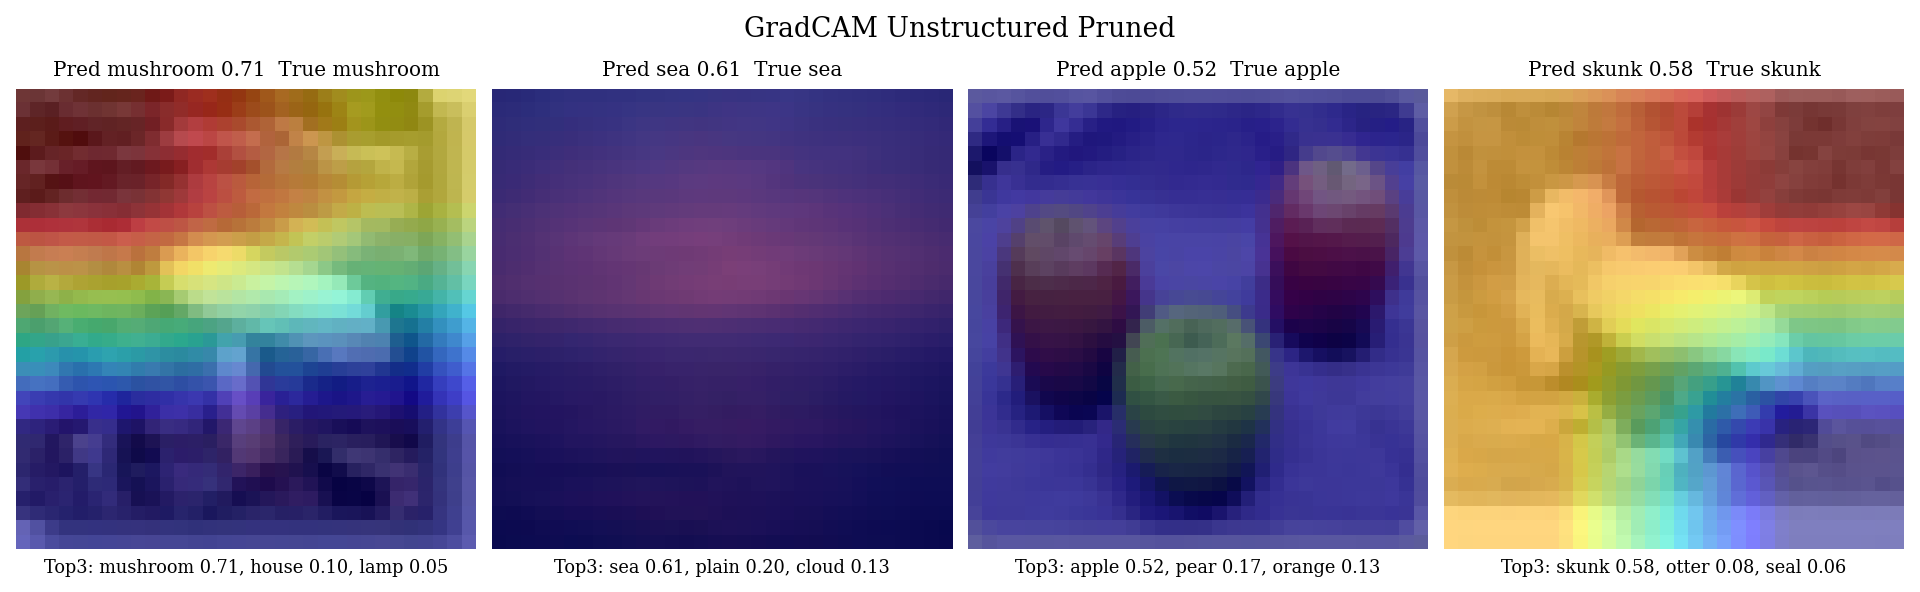

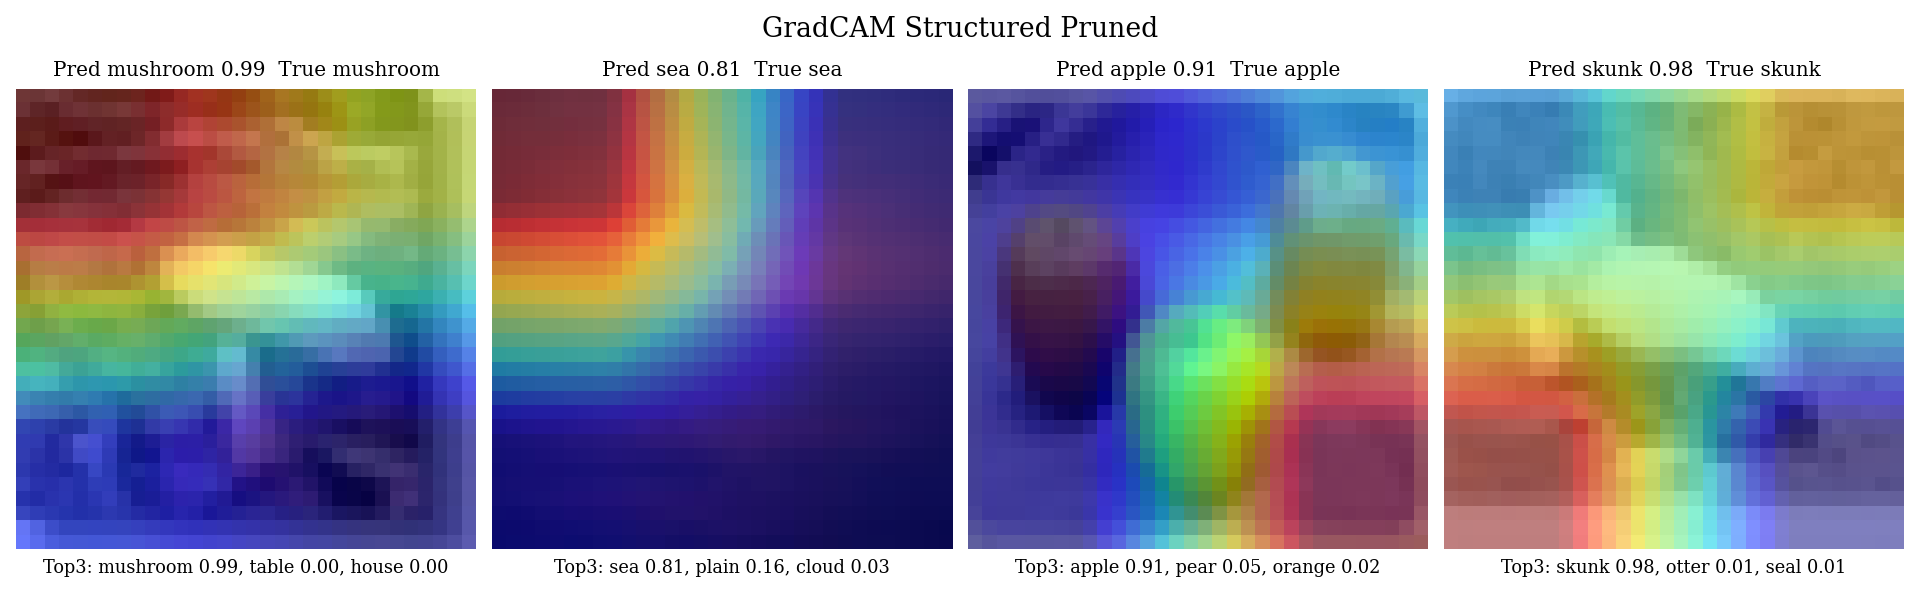

Saved: fig_cam_dense.png, fig_cam_un.png, fig_cam_st.png


In [18]:
# Cell 14 GradCAM comparison with labels, confidence, and correctness

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR100

TOPK = 3  # keep as-is; only used for small subtitles

# ----- class names (works for CIFAR100 test loader) -----
try:
    CLASS_NAMES = test_loader.dataset.classes
except Exception:
    CLASS_NAMES = CIFAR100(root=".", download=False).classes

# ----- last conv locator (for Grad-CAM) -----
def _last_conv_layer(model):
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise RuntimeError("No Conv2d layer found for GradCAM target")
    return last

# ----- de-normalize to RGB [0,1] (CIFAR-100 stats) -----
CIFAR_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR_STD  = (0.2675, 0.2565, 0.2761)

def _to_rgb01(x, mean=CIFAR_MEAN, std=CIFAR_STD):
    x = x.detach().cpu().clone()
    for c in range(3):
        x[:, c] = x[:, c] * std[c] + mean[c]
    x = x.permute(0, 2, 3, 1).numpy()
    return np.clip(x, 0.0, 1.0)

# ----- pretty titles & correctness -----
def _pred_strings(logits, y_true):
    probs = F.softmax(logits, dim=1)
    conf, pred = probs.max(dim=1)
    titles = []
    for i in range(logits.size(0)):
        p_idx = pred[i].item()
        t_idx = int(y_true[i])
        p_name = CLASS_NAMES[p_idx]
        t_name = CLASS_NAMES[t_idx]
        topk_conf, topk_idx = probs[i].topk(min(TOPK, probs.size(1)))
        topk_txt = ", ".join([f"{CLASS_NAMES[topk_idx[j].item()]} {topk_conf[j].item():.2f}"
                              for j in range(topk_conf.numel())])
        titles.append((f"Pred {p_name} {conf[i].item():.2f}  True {t_name}", f"Top{TOPK}: {topk_txt}"))
    correct = pred.eq(y_true).float().cpu().numpy()
    return titles, correct

# ----- find SAME images all models get right -----
@torch.no_grad()
def select_consensus_correct(models, loader, n=4, min_conf=0.20, device=None):
    if device is None:
        device = next(models[0].parameters()).device
    chosen = []
    for x, y in loader:
        x = x.to(device); y = y.to(device)
        ok = torch.ones(y.size(0), dtype=torch.bool, device=device)
        for m in models:
            m.eval()
            logits = m(x)
            probs = F.softmax(logits, dim=1)
            conf, pred = probs.max(dim=1)
            ok &= (pred == y) & (conf >= min_conf)
        idx = torch.nonzero(ok).squeeze(1)
        for i in idx.tolist():
            chosen.append((x[i:i+1].cpu(), y[i:i+1].cpu()))
            if len(chosen) == n:
                xs = torch.cat([t[0] for t in chosen], 0)
                ys = torch.cat([t[1] for t in chosen], 0)
                return xs, ys
    # If we got here, relax confidence requirement and retry once:
    if min_conf > 0.0:
        return select_consensus_correct(models, loader, n=n, min_conf=0.0, device=device)
    raise RuntimeError(f"Could not find {n} consensus-correct samples. Try lowering n.")

# ----- Grad-CAM grid (uses pytorch-grad-cam's GradCAM & show_cam_on_image already in your notebook) -----
def gradcam_grid(model, images, labels, big_title, device, save_path=None):
    model.eval()
    with torch.no_grad():
        logits = model(images.to(device))
    target_layer = _last_conv_layer(model)
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=(device.type=="cuda"))

    inp = images.to(device)
    heat = cam(input_tensor=inp)  # [N,h,w] in [0,1]
    heat_t = torch.from_numpy(heat).unsqueeze(1).float()
    H, W = images.shape[-2], images.shape[-1]
    heat_up = F.interpolate(heat_t, size=(H, W), mode="bilinear", align_corners=False)
    heat_up = heat_up.squeeze(1).clamp(0, 1).cpu().numpy()

    titles, _ = _pred_strings(logits.cpu(), labels.cpu())
    imgs = _to_rgb01(images)
    n = images.size(0)

    plt.figure(figsize=(3.0*n, 3.6))
    for i in range(n):
        vis = show_cam_on_image(imgs[i], heat_up[i], alpha=0.5)
        ax = plt.subplot(1, n, i+1)
        ax.imshow(vis)
        ax.set_title(titles[i][0], fontsize=9)
        ax.set_xlabel(titles[i][1], fontsize=8)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.suptitle(big_title, y=0.99, fontsize=12)
    plt.tight_layout(pad=0.6)
    if save_path is not None:
        plt.savefig(save_path, dpi=220, bbox_inches="tight")
    plt.show()

# ===== RUN: pick consensus-correct samples & render three panels =====
DEVICE = next(vgg.parameters()).device  # assumes vgg exists

models = [vgg, vgg_unstruct, vgg_struct]
imgs, lbls = select_consensus_correct(models, test_loader, n=4, min_conf=0.20, device=DEVICE)

# Dense
gradcam_grid(vgg, imgs, lbls, "GradCAM Dense", DEVICE, save_path="fig_cam_dense.png")
# Unstructured
gradcam_grid(vgg_unstruct, imgs, lbls, "GradCAM Unstructured Pruned", DEVICE, save_path="fig_cam_un.png")
# Structured
gradcam_grid(vgg_struct, imgs, lbls, "GradCAM Structured Pruned", DEVICE, save_path="fig_cam_st.png")

print("Saved: fig_cam_dense.png, fig_cam_un.png, fig_cam_st.png")

latency ms cpu
dense 90.05 unstructured 97.32 structured-70 37.97
params count
dense 129181540 unstructured nonzeros 38766041 structured-70 90833526


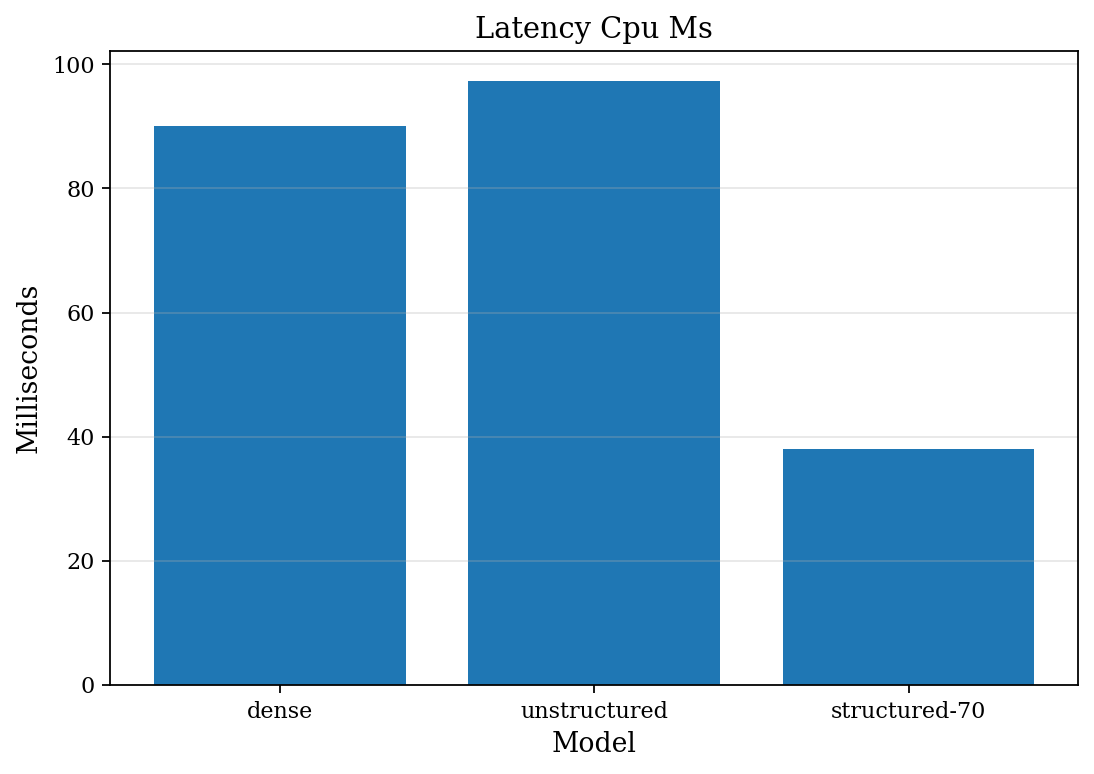

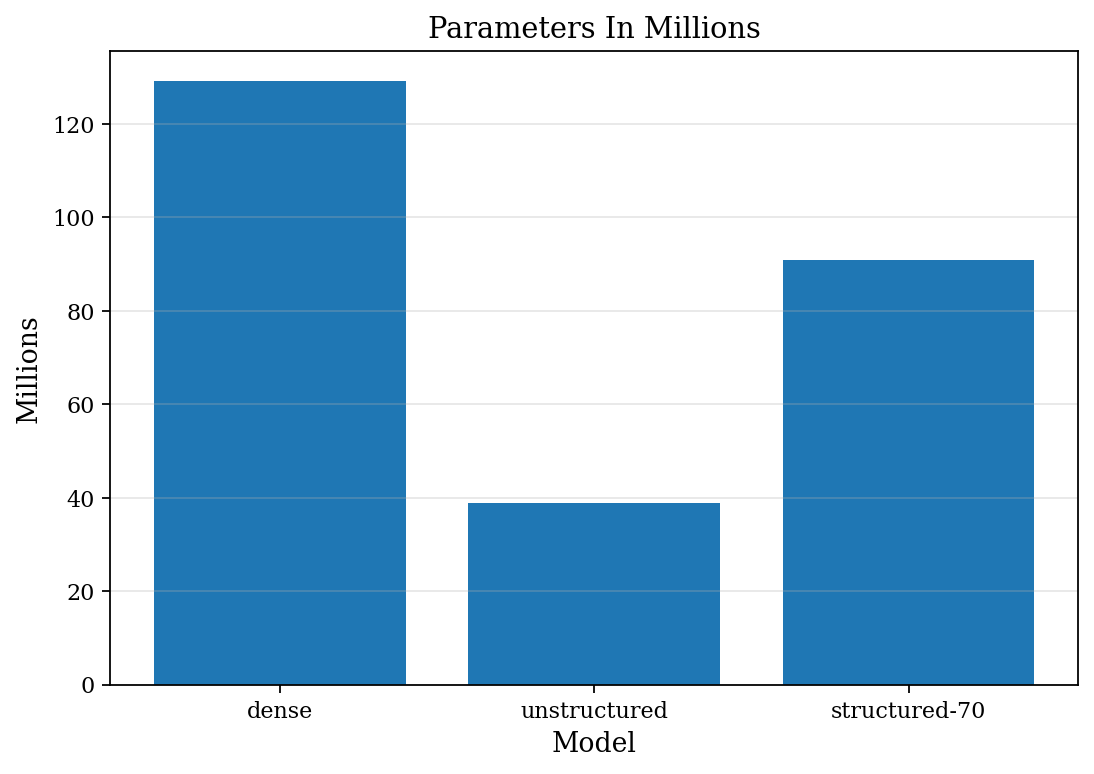

In [19]:
# ===== Cell 15 (REPLACE): Inference time and params with structured-70 =====
dense_cpu_ms = measure_latency_ms(vgg, on="cpu")
un_cpu_ms   = measure_latency_ms(vgg_unstruct, on="cpu")
st_cpu_ms   = measure_latency_ms(vgg_struct, on="cpu")   # vgg_struct is now the 70% model

dense_params = sum(p.numel() for p in vgg.parameters())
un_params_nz = sum(p.count_nonzero().item() for p in vgg_unstruct.parameters())
st_params    = sum(p.numel() for p in vgg_struct.parameters())

print("latency ms cpu")
print("dense", round(dense_cpu_ms,2), "unstructured", round(un_cpu_ms,2), "structured-70", round(st_cpu_ms,2))
print("params count")
print("dense", dense_params, "unstructured nonzeros", un_params_nz, "structured-70", st_params)

labels = ["dense", "unstructured", "structured-70"]
lat   = [dense_cpu_ms, un_cpu_ms, st_cpu_ms]

plt.figure(figsize=(7, 5))
plt.bar(labels, lat)
plt.title("Latency Cpu Ms")
plt.xlabel("Model")
plt.ylabel("Milliseconds")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

pars  = [dense_params, un_params_nz, st_params]
plt.figure(figsize=(7, 5))
plt.bar(labels, [p/1e6 for p in pars])
plt.title("Parameters In Millions")
plt.xlabel("Model")
plt.ylabel("Millions")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


sparsity 0.30 accuracy 62.63
sparsity 0.50 accuracy 61.89
sparsity 0.60 accuracy 62.03
sparsity 0.70 accuracy 61.37
sparsity 0.85 accuracy 58.74


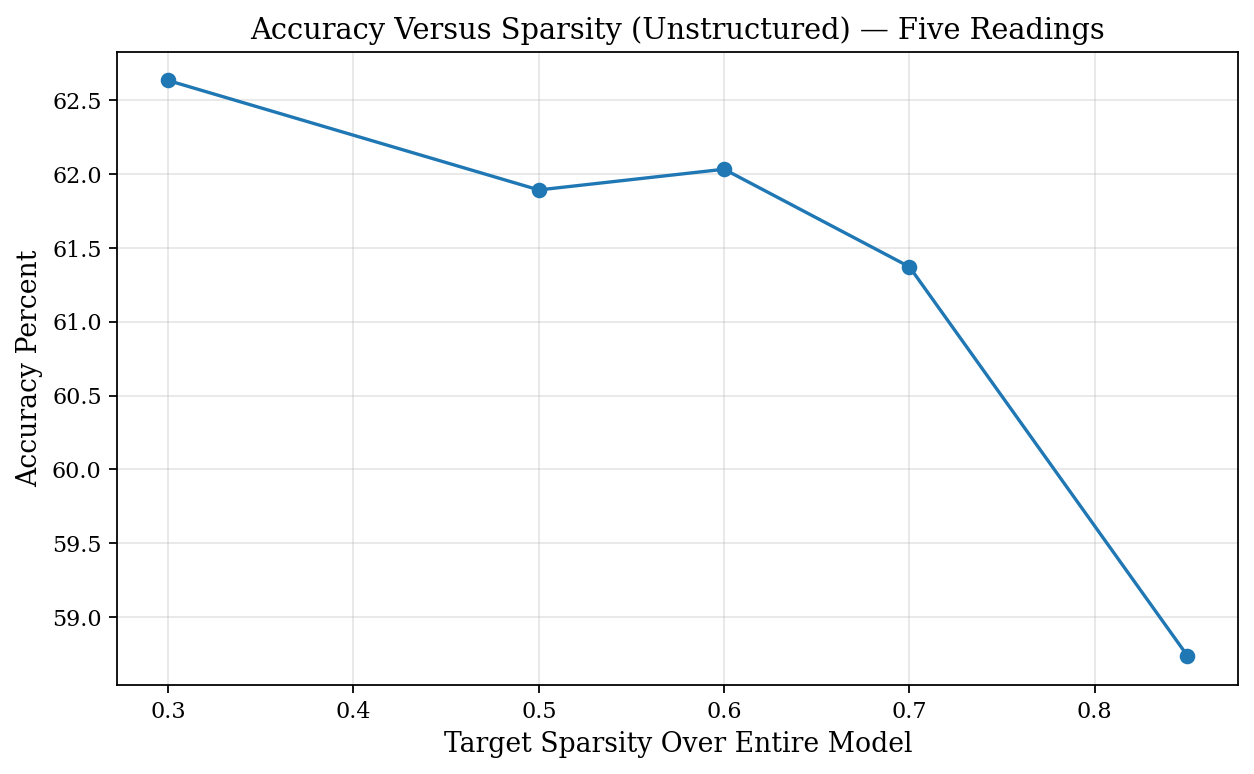

In [20]:
# Cell 16 Accuracy versus target sparsity curve single method five points

# we produce a curve for unstructured by sweeping global sparsity levels and finetuning briefly
import copy, gc, torch
import matplotlib.pyplot as plt
from torch.optim import SGD

#starting clean and in FP32
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float32)

# keep a CPU FP32 master to avoid any leftover half/bfloat params from earlier cells
vgg_master_fp32 = vgg.to("cpu").float()

levels = [0.30, 0.50, 0.60, 0.70, 0.85]
accs_curve = []

for s in levels:
    # fresh FP32 model on GPU
    m = copy.deepcopy(vgg_master_fp32).to("cuda").float()

    # uniform per-layer sparsity plan (only weight tensors: dim>1)
    plan_unif = {n: s for n, p in m.named_parameters() if p.dim() > 1}
    pr = FineGrainedPruner(m, plan_unif)

    # APPLY PRUNING ONCE BEFORE TRAINING (static mask); avoids needing callbacks
    pr.apply(m)

    # one-epoch finetune in pure FP32 (NO autocast / NO use_amp arg)
    opt = SGD(m.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    try:
        # simplest common signature
        train_one_epoch(m, train_loader, opt)
    except TypeError:
        # some versions expect a scheduler positional param; pass None
        train_one_epoch(m, train_loader, opt, None)

    # evaluate without AMP
    try:
        a = evaluate(m, test_loader, verbose=False)
    except TypeError:
        a = evaluate(m, test_loader)

    accs_curve.append(a)
    print(f"sparsity {s:.2f} accuracy {a:.2f}")

    # cleanup before next point
    del m, opt, pr
    gc.collect()
    torch.cuda.empty_cache()

# plot
plt.figure(figsize=(8, 5))
plt.plot(levels, accs_curve, marker="o")
plt.xlabel("Target Sparsity Over Entire Model")
plt.ylabel("Accuracy Percent")
plt.title("Accuracy Versus Sparsity (Unstructured) — Five Readings")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

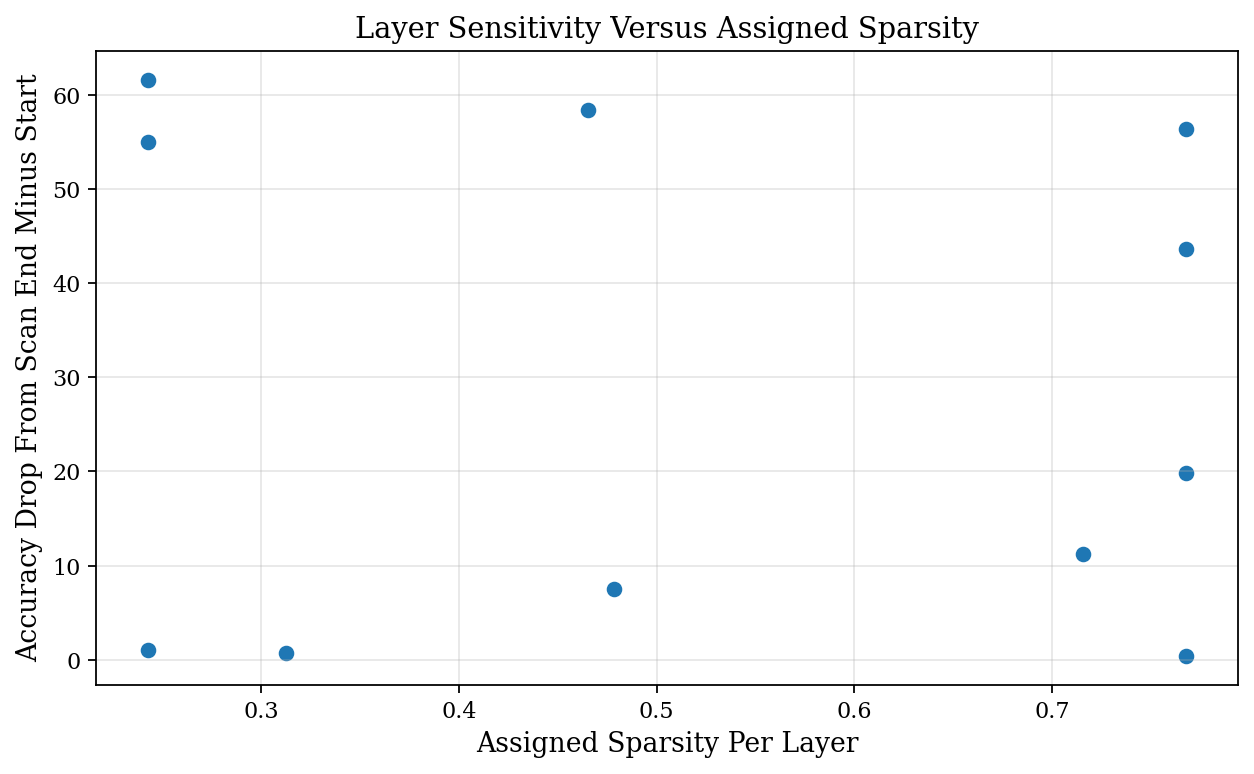

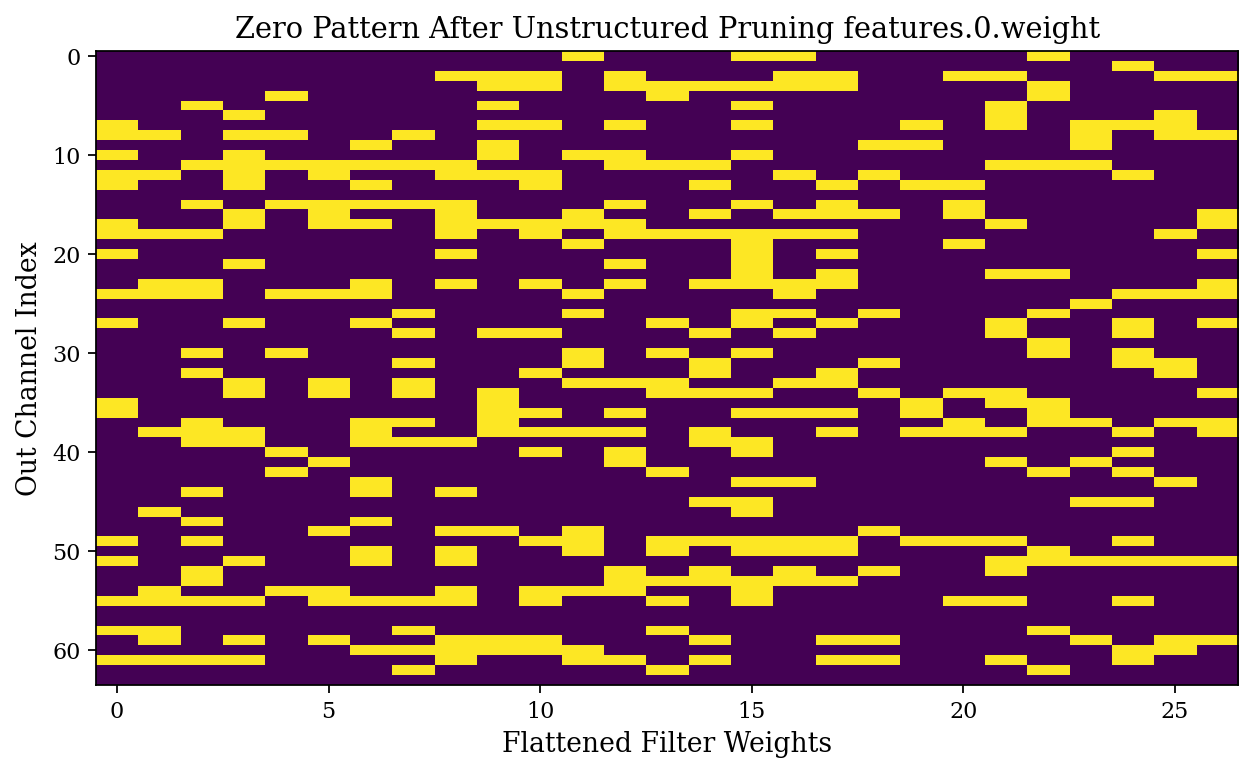

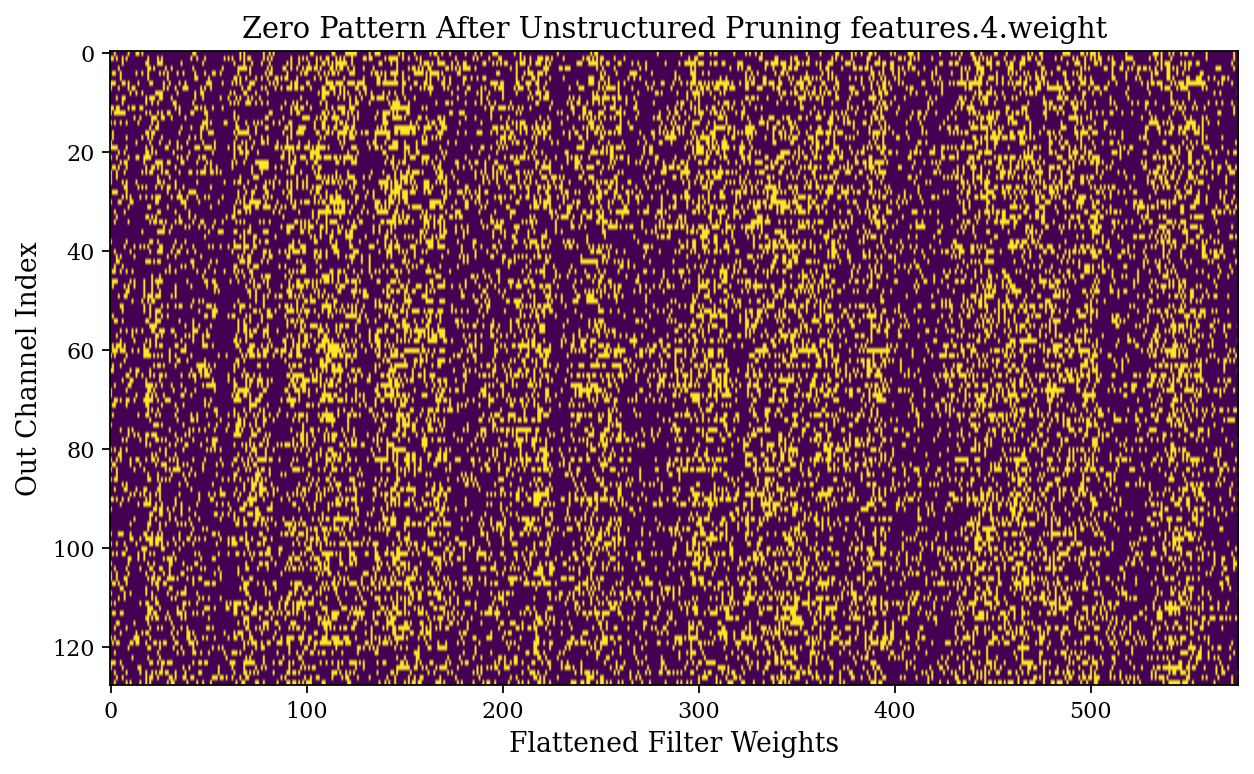

In [21]:
# Cell 17 Extra analysis research grade figures and checks

# figure one per layer sparsity versus estimated sensitivity correlation
# this supports discussion that early layers tend to be more sensitive

drops = []
final_s = []
for name in scan_res:
    accs = scan_res[name]
    drop = accs[0] - accs[-1]
    drops.append(drop)
    final_s.append(plan[name])

plt.figure(figsize=(8, 5))
plt.scatter(final_s, drops)
plt.xlabel("Assigned Sparsity Per Layer")
plt.ylabel("Accuracy Drop From Scan End Minus Start")
plt.title("Layer Sensitivity Versus Assigned Sparsity")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# figure two mask density images for two representative layers to visualize internal structure after pruning
def show_mask_patterns(model, title):
    mats = []
    names = []
    for n, p in model.named_parameters():
        if p.dim() > 1 and p.shape[0] >= 32:
            arr = (p.detach().cpu().numpy() == 0).astype(np.float32)
            mats.append(arr.reshape(arr.shape[0], -1))
            names.append(n)
        if len(mats) == 2:
            break
    for i in range(len(mats)):
        plt.figure(figsize=(8, 5))
        plt.imshow(mats[i], aspect="auto")
        plt.title(f"{title} {names[i]}")
        plt.xlabel("Flattened Filter Weights")
        plt.ylabel("Out Channel Index")
        plt.tight_layout()
        plt.show()

show_mask_patterns(vgg_unstruct, "Zero Pattern After Unstructured Pruning")


In [22]:
# Cell 18 Final Summary Safe

# this cell safely recomputes any missing variables so summary never crashes
# it also prints clean, report-ready lines

import torch

# helper
def model_sparsity(model: torch.nn.Module) -> float:
    nz, tot = 0, 0
    for p in model.parameters():
        if p is None:
            continue
        t = p.detach()
        nz += int(t.count_nonzero())
        tot += t.numel()
    return 0.0 if tot == 0 else 1.0 - (nz / tot)

# safe evaluate
@torch.inference_mode()
def _safe_acc(m):
    if m is None:
        return None
    m.eval()
    try:
        return evaluate(m, test_loader, verbose=False)
    except NameError:
        # fallback if your evaluate() has a different signature
        correct = 0
        total = 0
        device = next(m.parameters()).device
        for x,y in test_loader:
            x = x.to(device); y = y.to(device)
            logits = m(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.numel()
        return 100.0 * correct / max(total, 1)

# dense
try:
    dense_acc
except NameError:
    dense_acc = _safe_acc(vgg)

# unstructured
try:
    acc_un
except NameError:
    try:
        acc_un = _safe_acc(vgg_unstruct)
    except NameError:
        acc_un = None

try:
    overall_spars_un = model_sparsity(vgg_unstruct)
except NameError:
    overall_spars_un = None

# structured
try:
    acc_struct
except NameError:
    try:
        acc_struct = _safe_acc(vgg_struct)
    except NameError:
        acc_struct = None

# accuracy vs sparsity curve (optional)
try:
    curve_levels = [float(x) for x in levels]
    curve_accs   = [float(a) for a in accs_curve]
    curve_dict   = {round(k,2): round(v,2) for k,v in zip(curve_levels, curve_accs)}
except NameError:
    curve_dict = None

print("Baseline Accuracy:", f"{dense_acc:.2f}%")
if acc_un is not None:
    print("Unstructured Accuracy:", f"{acc_un:.2f}%",
          "| Overall Sparsity:", "N/A" if overall_spars_un is None else f"{overall_spars_un:.3f}")
else:
    print("Unstructured Accuracy: N/A (vgg_unstruct not present)")

if acc_struct is not None:
    print("Structured Accuracy:", f"{acc_struct:.2f}%")
else:
    print("Structured Accuracy: N/A (vgg_struct not present)")

if curve_dict is not None and len(curve_dict) > 0:
    print("Accuracy Versus Sparsity Points:", curve_dict)
else:
    print("Accuracy Versus Sparsity Points: N/A (curve not computed in this run)")

# print("Done Task 1 end to end")


Baseline Accuracy: 64.61%
Unstructured Accuracy: 55.66% | Overall Sparsity: 0.700
Structured Accuracy: 61.46%
Accuracy Versus Sparsity Points: {0.3: 62.63, 0.5: 61.89, 0.6: 62.03, 0.7: 61.37, 0.85: 58.74}


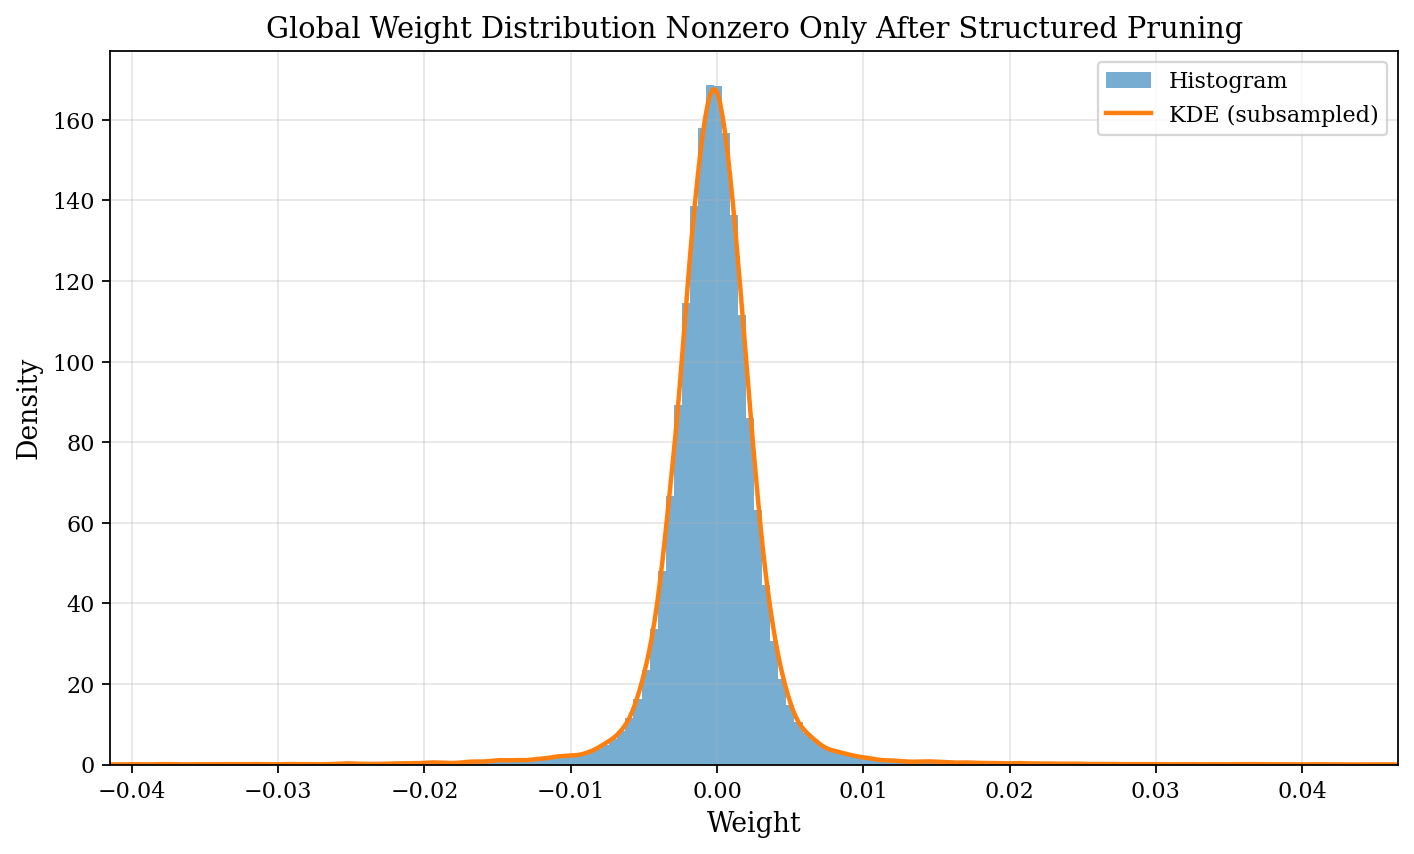

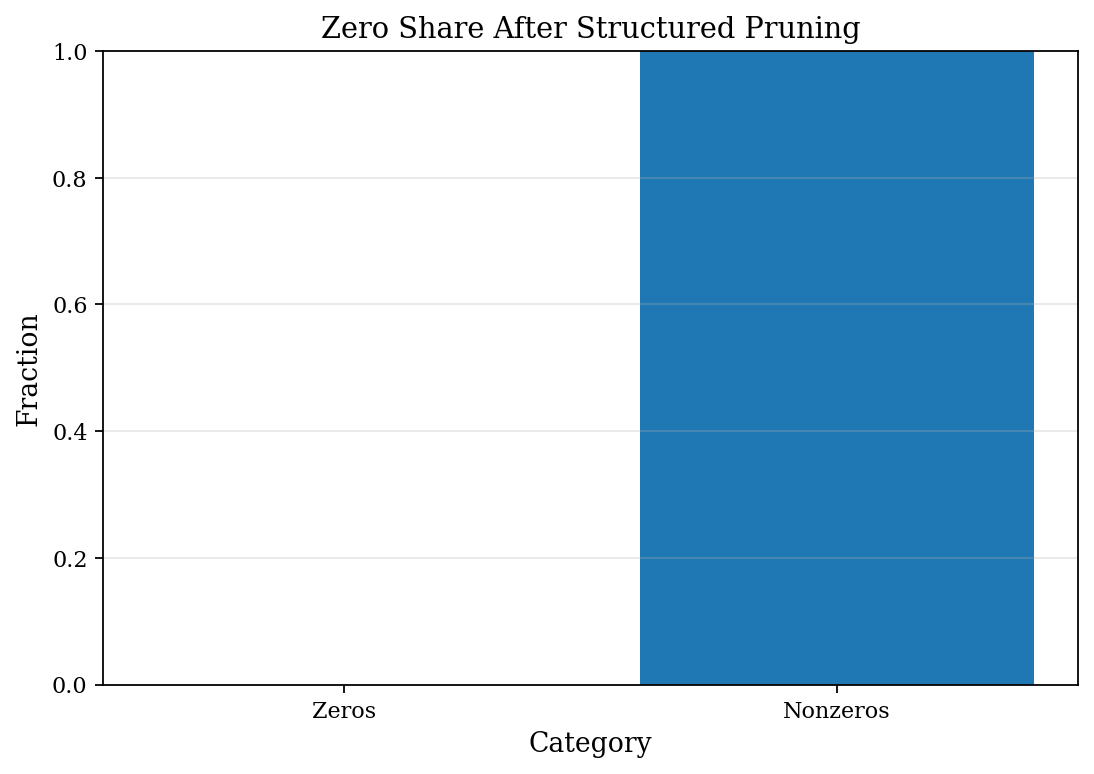

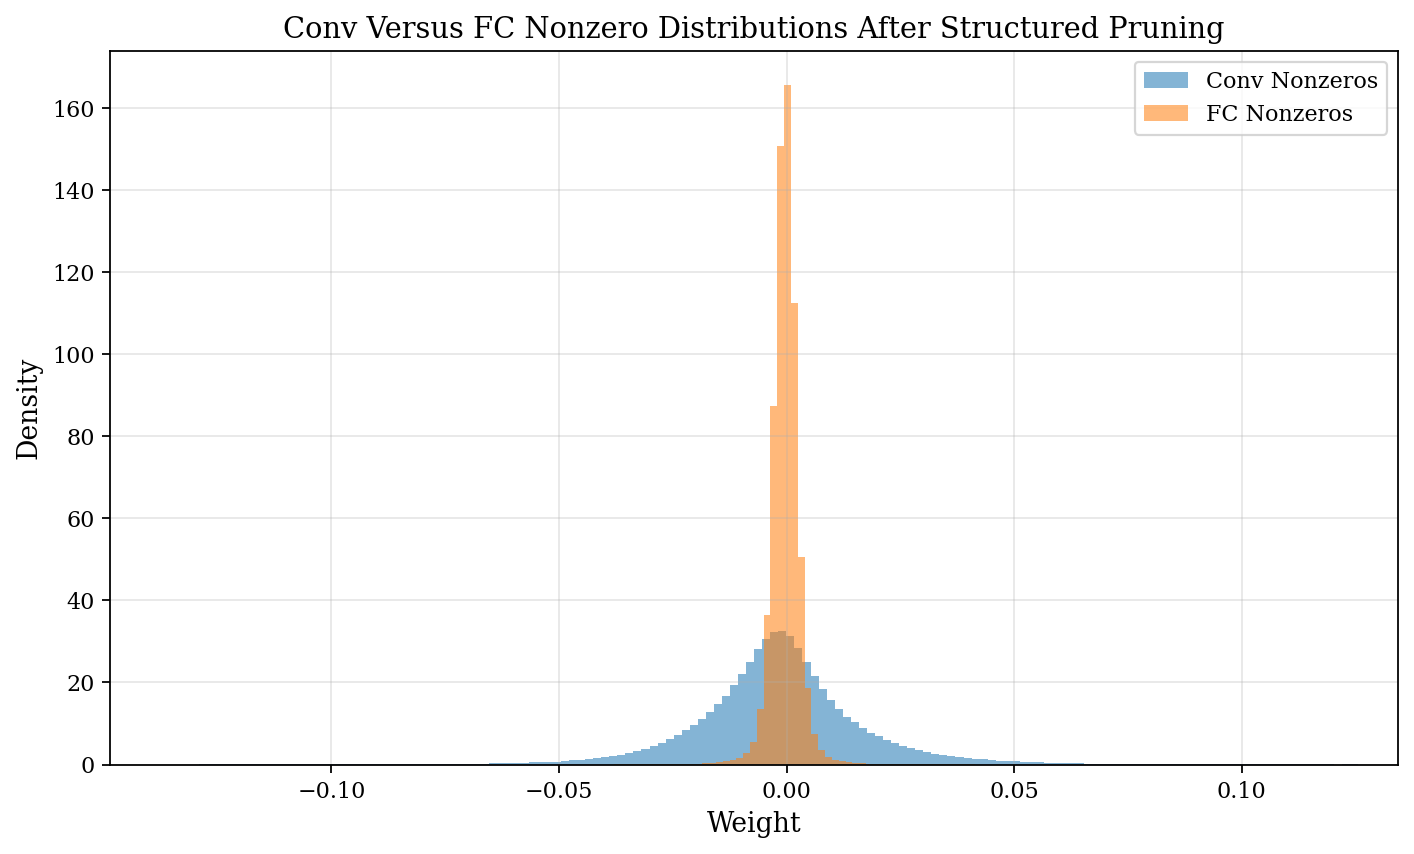

Layer Stats After Structured Pruning
Layer                                     Mean       Std      Skew   Kurtosis    Sparsity
features.0.weight                      -0.0012    0.3353    -0.138     +0.577      0.000
features.4.weight                      -0.0095    0.0720    -0.061     +3.422      0.000
features.8.weight                      -0.0036    0.0376    +0.094     +1.101      0.000
features.11.weight                     -0.0042    0.0303    +0.326     +0.698      0.000
features.15.weight                     -0.0009    0.0218    +0.282     +0.528      0.000
features.18.weight                     -0.0008    0.0160    +0.342     +0.704      0.000
features.22.weight                     -0.0012    0.0137    +0.206     +1.407      0.000
features.25.weight                     -0.0016    0.0122    +0.500     +3.738      0.000
classifier.0.weight                    -0.0002    0.0024    +0.145     +0.959      0.000
classifier.3.weight                    -0.0004    0.0051    +0.296     +

In [23]:
# Cell 19 Plot weight distributions AFTER structured pruning FAST

# replace your entire Cell 19 with this cell

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

def plot_after_structured(model, pclip=(0.05, 99.95), add_kde=True):
    # reuse helpers from Cell 06 (assumes they exist in notebook)
    buckets = _collect_weights(model)
    allw, conv, fc = buckets["all"], buckets["conv"], buckets["fc"]
    nz = allw[allw != 0]
    zeros_frac = float((allw == 0).mean())

    # Global nonzero histogram + KDE
    lo, hi = _robust_xlim(nz, pclip[0], pclip[1])
    xs = nz[(nz >= lo) & (nz <= hi)]
    plt.figure(figsize=(9, 5.5))
    plt.hist(xs, bins=_fd_bins(xs), density=True, alpha=0.6, label="Histogram")
    if add_kde:
        grid, dens = _kde_curve(xs, lo, hi)
        if grid is not None:
            plt.plot(grid, dens, linewidth=2, label="KDE (subsampled)")
    plt.title("Global Weight Distribution Nonzero Only After Structured Pruning")
    plt.xlabel("Weight"); plt.ylabel("Density")
    plt.xlim(lo, hi); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # Zero share bar
    plt.figure(figsize=(7, 5))
    plt.bar(["Zeros", "Nonzeros"], [zeros_frac, 1 - zeros_frac])
    plt.title("Zero Share After Structured Pruning")
    plt.xlabel("Category"); plt.ylabel("Fraction")
    plt.ylim(0, 1); plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

    # Conv vs FC nonzero overlay
    conv_nz = conv[conv != 0] if conv.size else np.array([])
    fc_nz   = fc[fc != 0] if fc.size else np.array([])
    if conv_nz.size and fc_nz.size:
        lo2 = min(_robust_xlim(conv_nz, pclip[0], pclip[1])[0], _robust_xlim(fc_nz, pclip[0], pclip[1])[0])
        hi2 = max(_robust_xlim(conv_nz, pclip[0], pclip[1])[1], _robust_xlim(fc_nz, pclip[0], pclip[1])[1])
    else:
        lo2, hi2 = lo, hi
    plt.figure(figsize=(9, 5.5))
    if conv_nz.size:
        xc = conv_nz[(conv_nz >= lo2) & (conv_nz <= hi2)]
        plt.hist(xc, bins=_fd_bins(xc), density=True, alpha=0.55, label="Conv Nonzeros")
    if fc_nz.size:
        xf = fc_nz[(fc_nz >= lo2) & (fc_nz <= hi2)]
        plt.hist(xf, bins=_fd_bins(xf), density=True, alpha=0.55, label="FC Nonzeros")
    plt.title("Conv Versus FC Nonzero Distributions After Structured Pruning")
    plt.xlabel("Weight"); plt.ylabel("Density")
    plt.xlim(lo2, hi2); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # Layer stats
    print("Layer Stats After Structured Pruning")
    print("{:<36} {:>9} {:>9} {:>9} {:>10} {:>11}".format(
        "Layer", "Mean", "Std", "Skew", "Kurtosis", "Sparsity"))
    for name, arr in buckets["layers"].items():
        mean = float(arr.mean()); std = float(arr.std())
        skew = float(st.skew(arr, bias=False)); kurt = float(st.kurtosis(arr, bias=False))
        spars = float((arr == 0).mean())
        print("{:<36} {:>+9.4f} {:>9.4f} {:>+9.3f} {:>+10.3f} {:>10.3f}".format(
            name, mean, std, skew, kurt, spars))

# Run after you’ve created vgg_struct
plot_after_structured(vgg_struct, pclip=(0.05, 99.95), add_kde=True)


/tmp/ipython-input-2913082194.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():        # mixed precision to save memory


scanned conv0 ratios [0.2, 0.5, 0.8] accs [62.58, 52.5, 8.54]
scanned conv1 ratios [0.2, 0.5, 0.8] accs [60.08, 36.82, 3.02]
scanned conv2 ratios [0.2, 0.5, 0.8] accs [62.71, 45.0, 7.76]
scanned conv3 ratios [0.2, 0.5, 0.8] accs [61.85, 41.28, 5.1]
scanned conv4 ratios [0.2, 0.5, 0.8] accs [62.99, 55.0, 26.85]
scanned conv5 ratios [0.2, 0.5, 0.8] accs [63.26, 56.8, 23.65]
scanned conv6 ratios [0.2, 0.5, 0.8] accs [64.17, 59.27, 29.77]


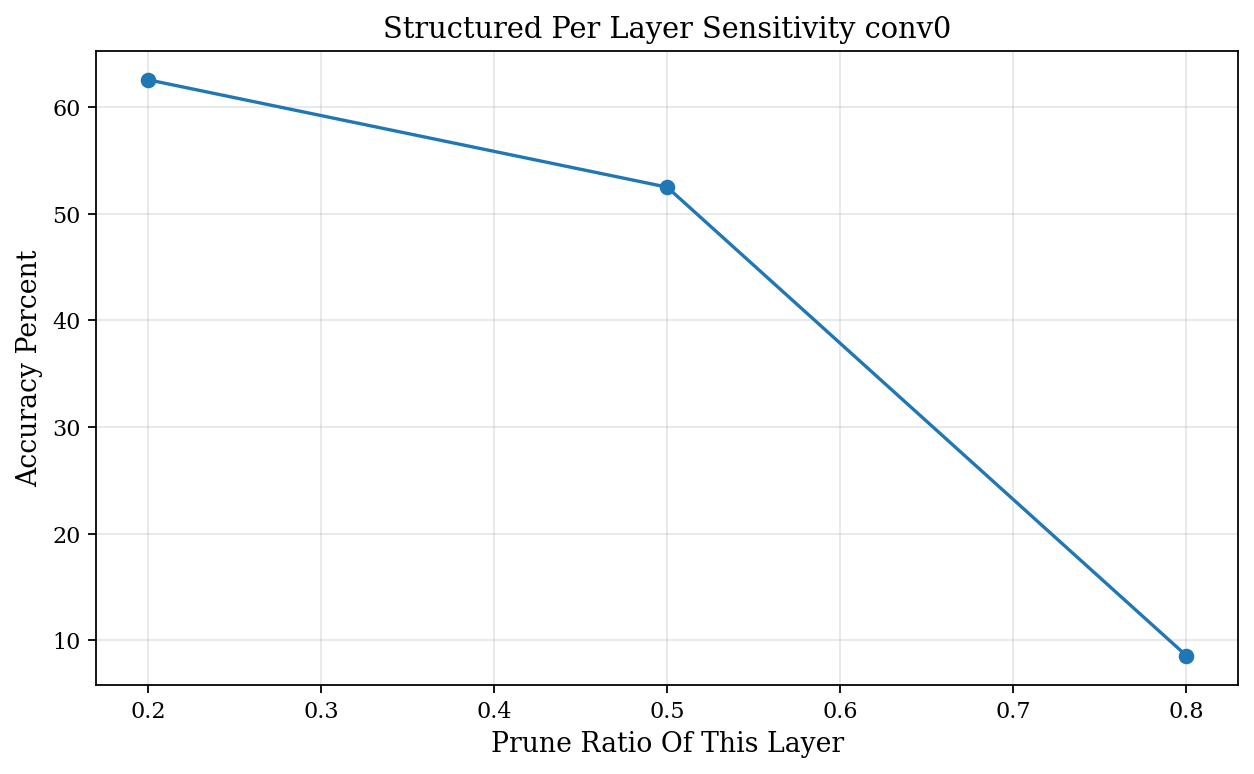

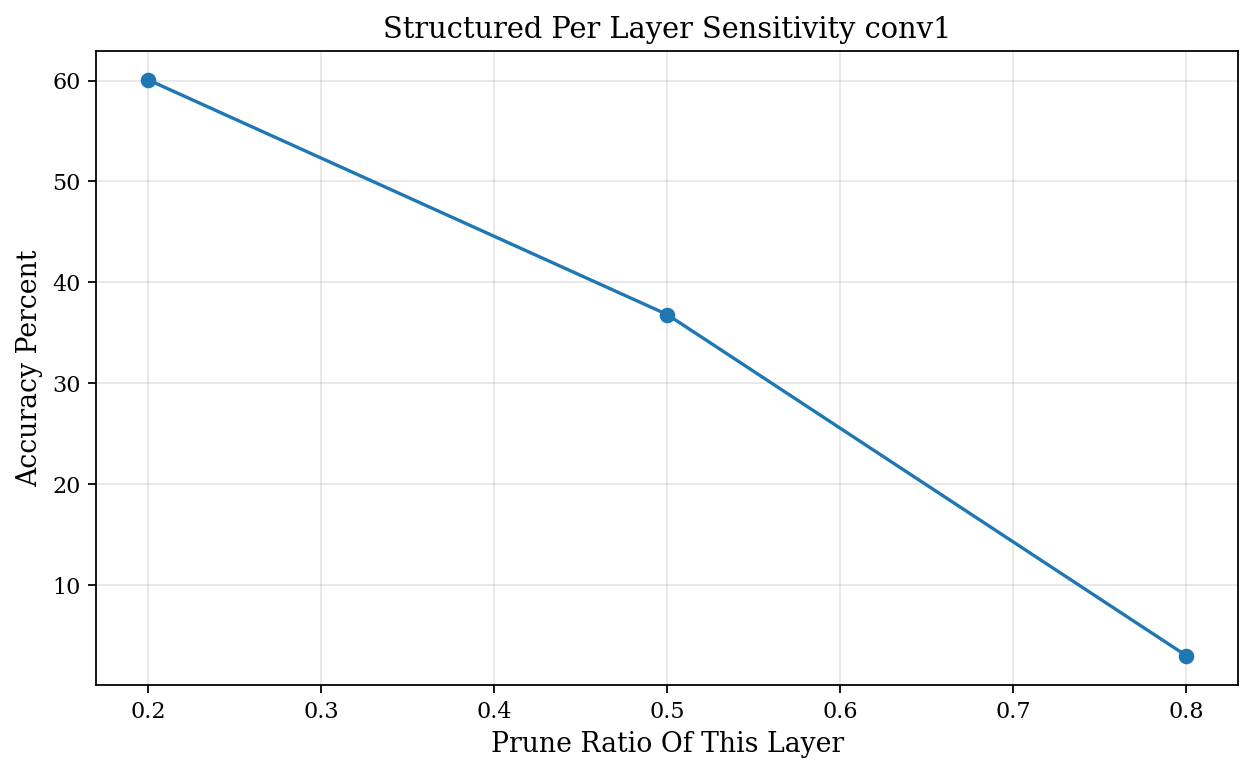

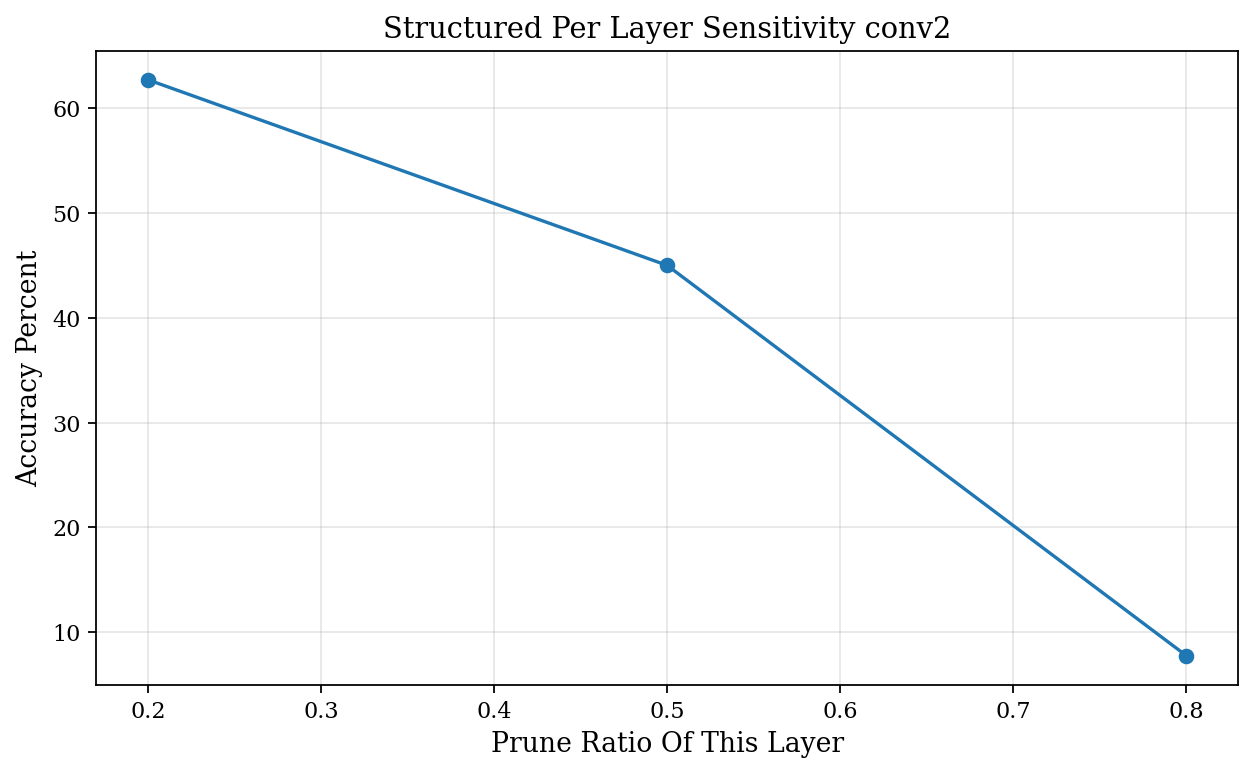

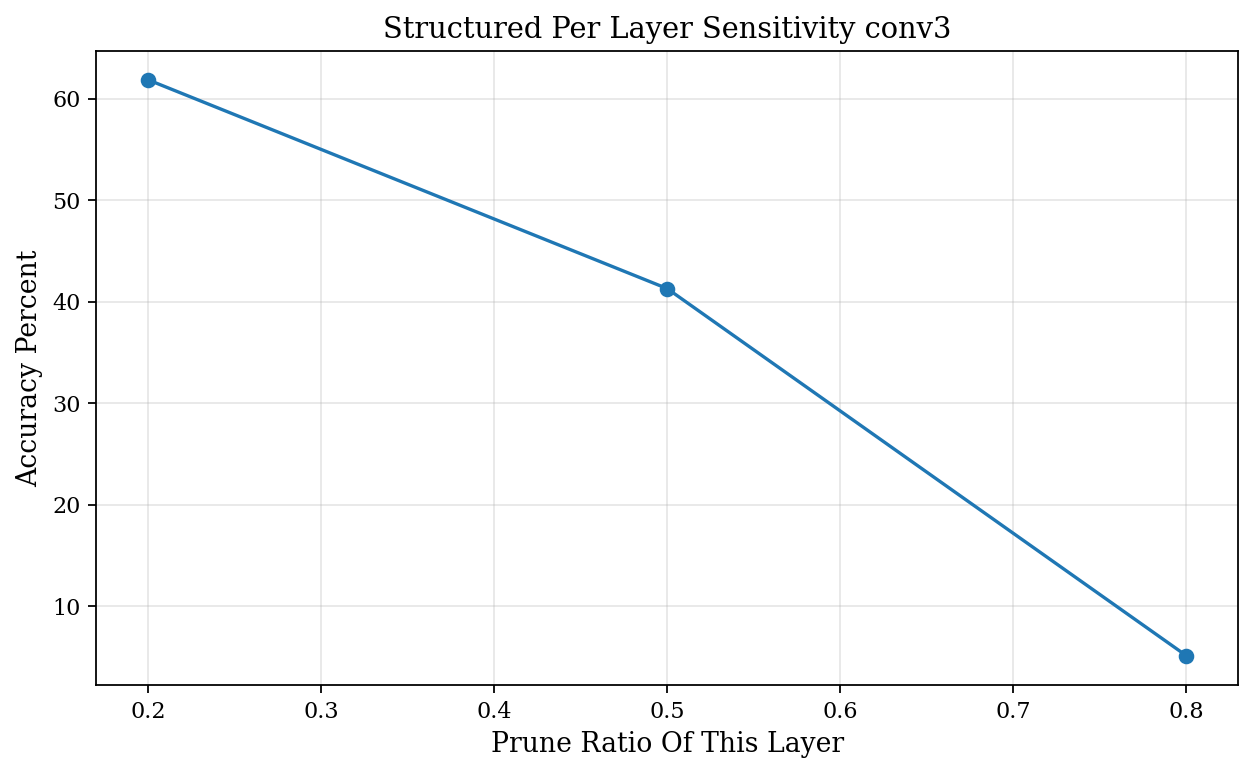

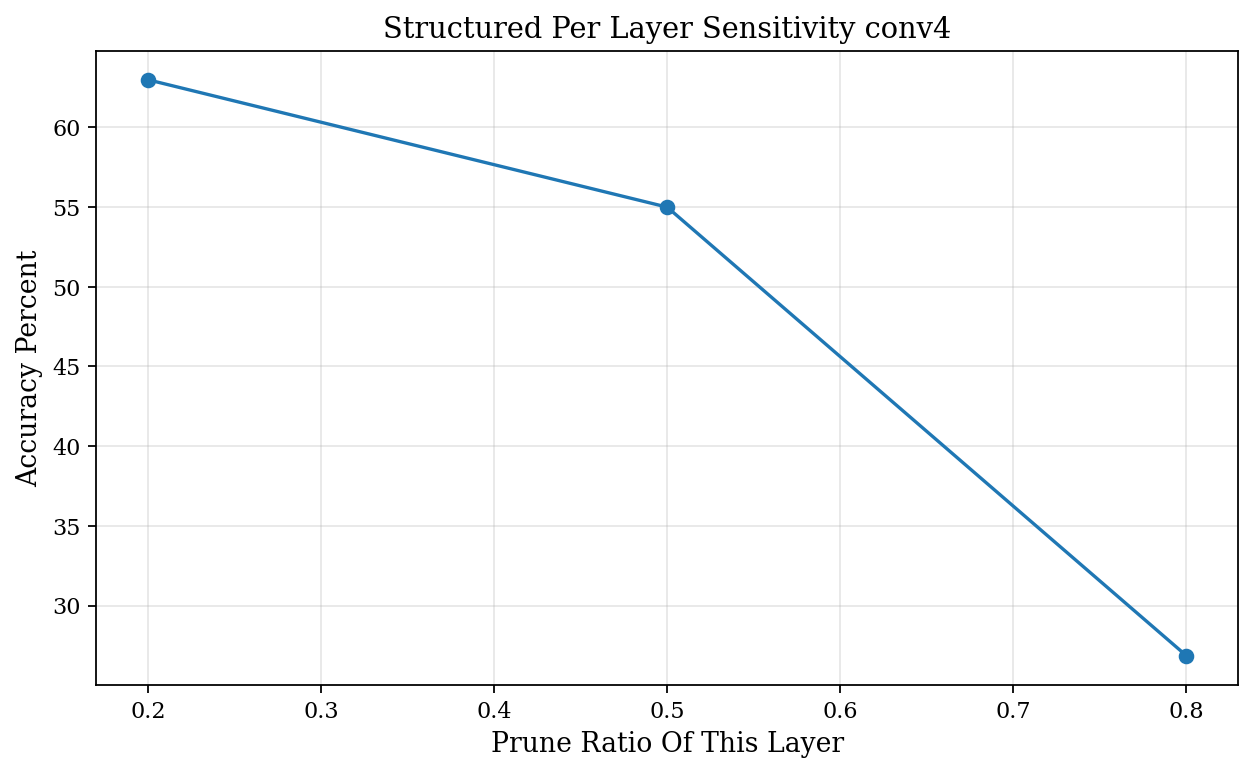

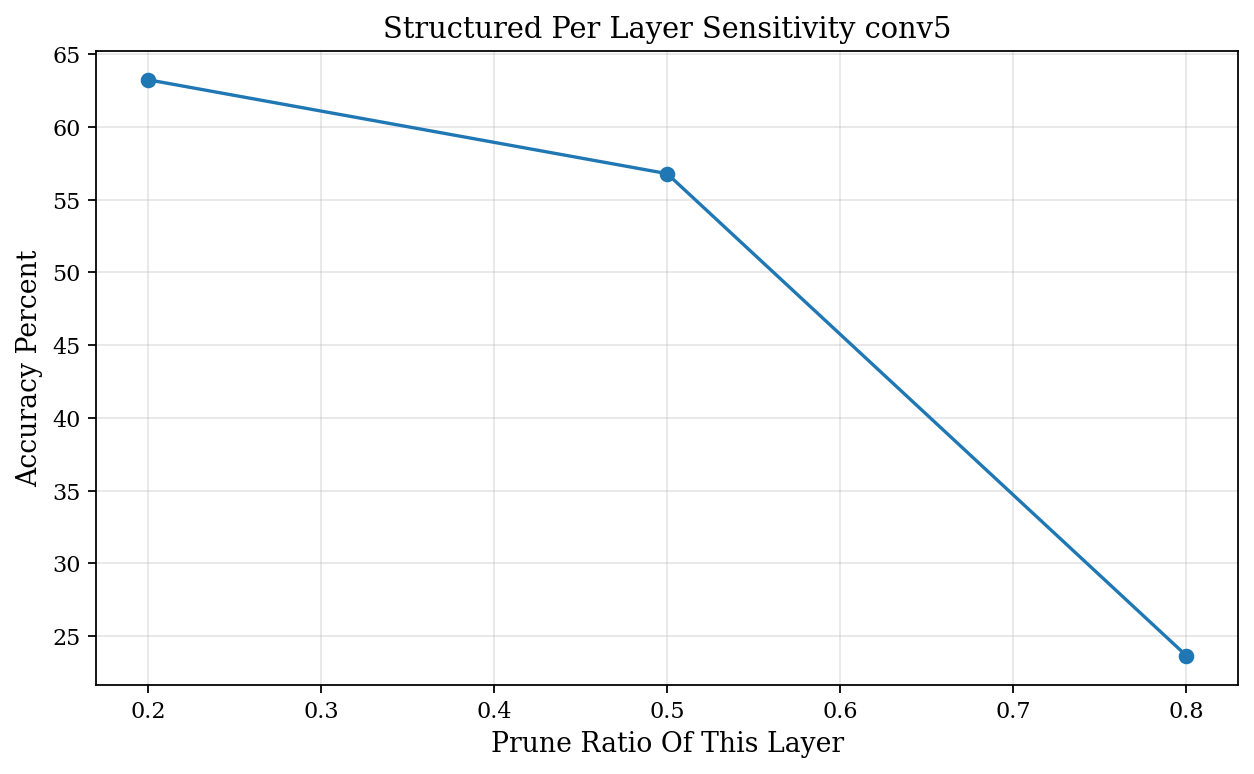

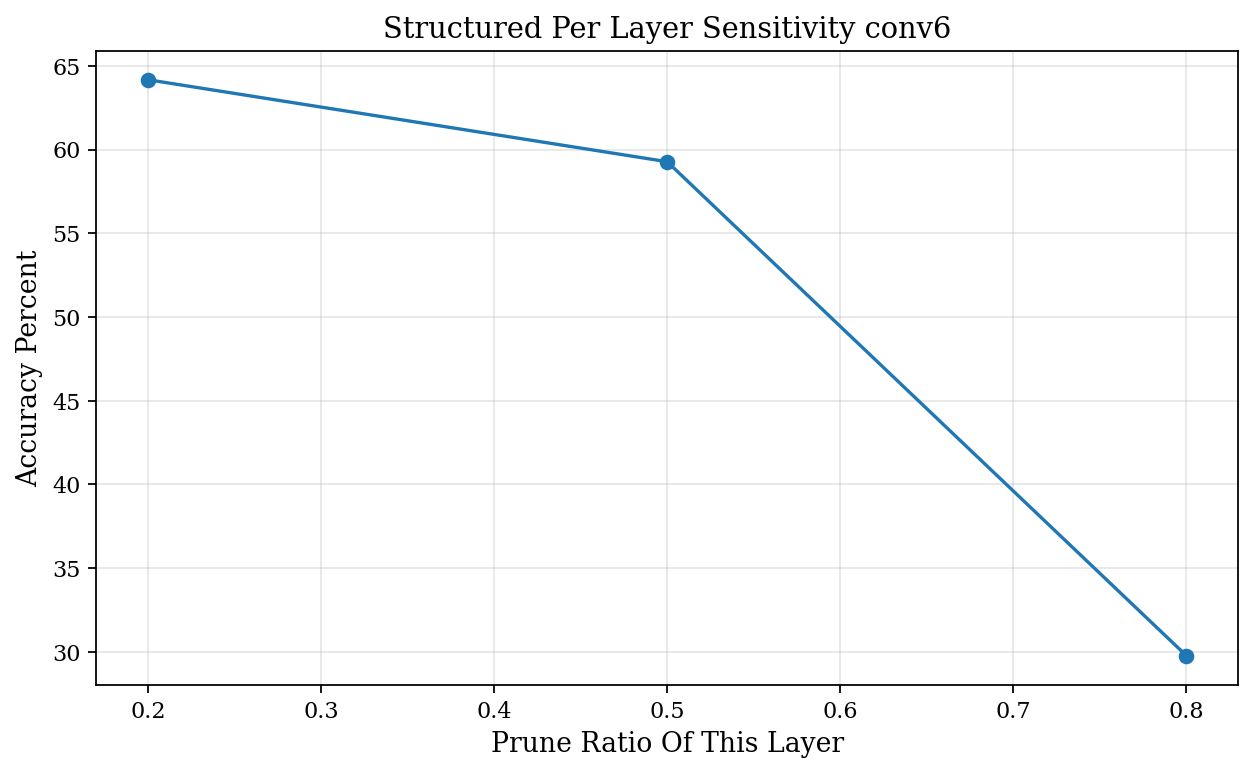

In [24]:
# Cell 20 Structured Per Layer Sensitivity Scan OOM Safe

# purpose measure which conv layers are more sensitive at a coarse level
# approach prune one conv layer at a time at several ratios restore and evaluate on cpu only
# note this avoids gpu cloning and fragmentation and deletes each temp model immediately

import copy, gc, torch
import torch.nn as nn
import matplotlib.pyplot as plt

@torch.inference_mode()
def _evaluate_gpu(model, loader, max_batches=15):
    model = model.to(DEVICE)
    model.eval()
    total, correct = 0, 0
    for bi, (x, y) in enumerate(loader):
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast():        # mixed precision to save memory
            logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
        if max_batches is not None and (bi + 1) >= max_batches:
            break
    return 100.0 * correct / max(1, total)

@torch.inference_mode()
def sensitivity_scan_structured_per_layer_gpu(model, loader, ratios=(0.2, 0.5, 0.8), max_batches=15):
    torch.cuda.empty_cache()
    base = copy.deepcopy(model).to(DEVICE, dtype=torch.float16)
    base.eval()

    convs = [m for m in base.features if isinstance(m, nn.Conv2d)]
    if len(convs) < 2:
        raise RuntimeError("expected >=2 conv layers in features for structured pruning scan")

    results = {}
    for idx in range(len(convs) - 1):
        accs = []
        for r in ratios:
            per_layer = {i: 0.0 for i in range(len(convs) - 1)}
            per_layer[idx] = float(r)

            # prune and evaluate in mixed precision
            m = structured_prune_model(base, per_layer).to(DEVICE, dtype=torch.float16)
            a = _evaluate_gpu(m, loader, max_batches=max_batches)
            accs.append(a)

            # cleanup
            del m
            gc.collect()
            torch.cuda.empty_cache()

        results[f"conv{idx}"] = accs
        print(f"scanned conv{idx} ratios {list(ratios)} accs {[round(x,2) for x in accs]}")

    del base
    gc.collect()
    torch.cuda.empty_cache()
    return ratios, results

# run on GPU with safe settings
struc_ratios, struc_layer_curves = sensitivity_scan_structured_per_layer_gpu(
    copy.deepcopy(vgg),
    test_loader,
    ratios=(0.2, 0.5, 0.8),
    max_batches=15
)

# plot results
for name, accs in struc_layer_curves.items():
    plt.figure(figsize=(8, 5))
    plt.plot(struc_ratios, accs, marker="o")
    plt.title(f"Structured Per Layer Sensitivity {name}")
    plt.xlabel("Prune Ratio Of This Layer")
    plt.ylabel("Accuracy Percent")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


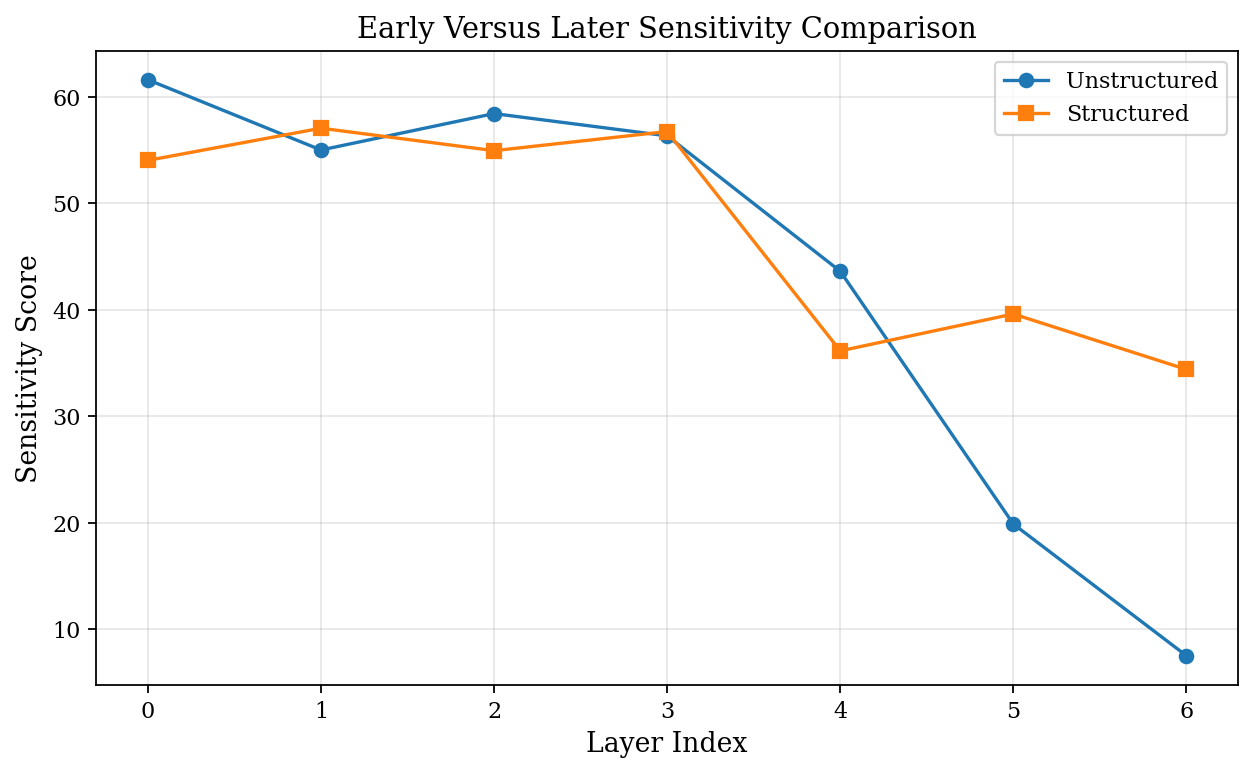

In [25]:
# Cell 21 Compare early versus later sensitivity between unstructured and structured

# we compute a simple sensitivity score as slope from first to last point
# then show a comparison plot as a single clear figure

uns_scores = []
layer_ids = []
for i, (name, accs) in enumerate(scan_res.items()):
    score = accs[0] - accs[-1]
    uns_scores.append(score)
    layer_ids.append(i)

str_scores = []
for i, (name, accs) in enumerate(struc_layer_curves.items()):
    score = accs[0] - accs[-1]
    str_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(layer_ids[:len(str_scores)], uns_scores[:len(str_scores)], marker="o", label="Unstructured")
plt.plot(layer_ids[:len(str_scores)], str_scores, marker="s", label="Structured")
plt.xlabel("Layer Index")
plt.ylabel("Sensitivity Score")
plt.title("Early Versus Later Sensitivity Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


ratio 0.10 accuracy 62.92
ratio 0.20 accuracy 61.71
ratio 0.30 accuracy 59.61
ratio 0.40 accuracy 56.48
ratio 0.50 accuracy 56.11


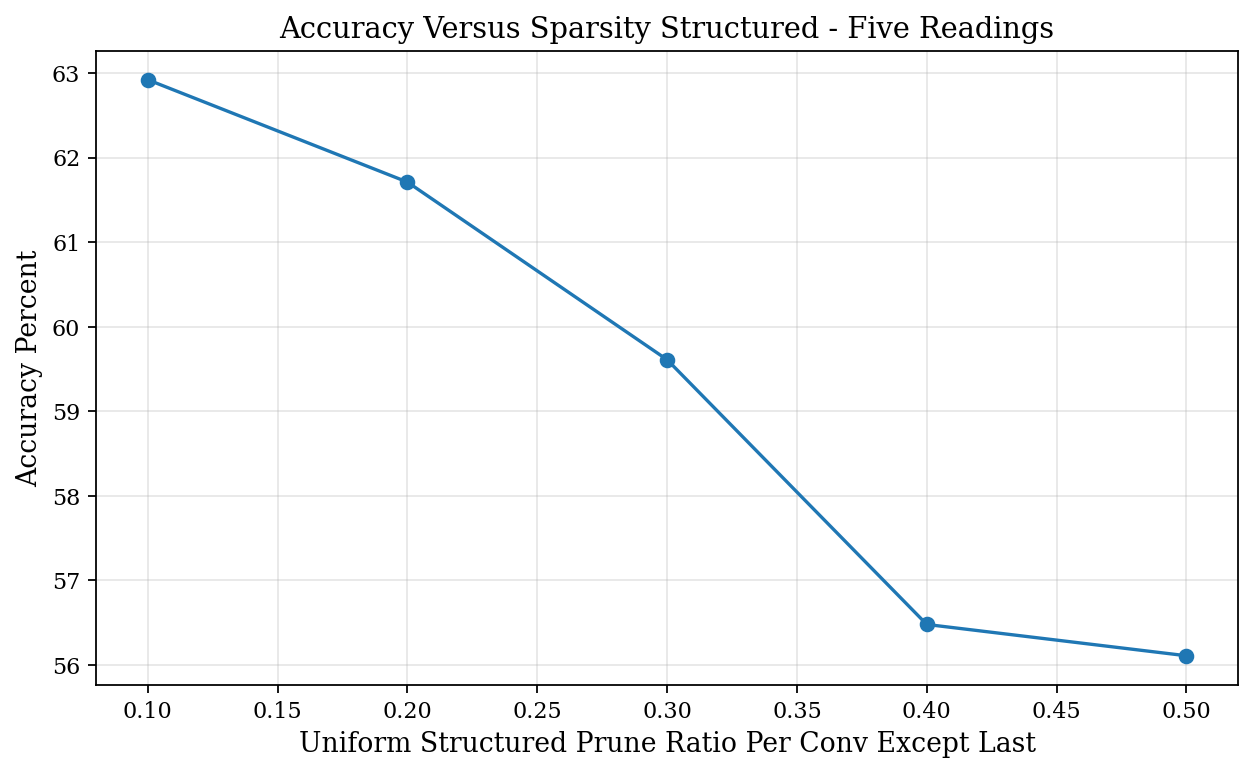

In [26]:
# Cell 22 Structured accuracy versus sparsity curve with five readings

# we sweep uniform structured prune ratios then quick finetune one epoch for fairness
# single clear figure with capitalized labels and title

# levels_struct = [0.10, 0.20, 0.30, 0.40, 0.50]
# accs_struct_curve = []

# for r in levels_struct:
#     ratios = {i: r for i in range(len([m for m in vgg.features if isinstance(m, nn.Conv2d)]) - 1)}
#     m = structured_prune_model(vgg, ratios).to(DEVICE)
#     opt = SGD(m.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
#     train_one_epoch(m, train_loader, opt)
#     a = evaluate(m, test_loader, verbose=False)
#     accs_struct_curve.append(a)
#     print(f"ratio {r:.2f} accuracy {a:.2f}")

# plt.figure(figsize=(8, 5))
# plt.plot(levels_struct, accs_struct_curve, marker="o")
# plt.xlabel("Uniform Structured Prune Ratio Per Conv Except Last")
# plt.ylabel("Accuracy Percent")
# plt.title("Accuracy Versus Sparsity Structured Five Readings")
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()



# Cell 22 Structured Accuracy vs Sparsity Curve (GPU-Safe Version)

# same logic but uses mixed precision and clears GPU memory each loop
import gc, torch
import matplotlib.pyplot as plt

levels_struct = [0.10, 0.20, 0.30, 0.40, 0.50]
accs_struct_curve = []

torch.cuda.empty_cache()

for r in levels_struct:
    # 1) Prune on CPU to avoid GPU fragmentation
    ratios = {i: r for i in range(len([m for m in vgg.features if isinstance(m, nn.Conv2d)]) - 1)}
    vgg_cpu = vgg.to("cpu")
    m = structured_prune_model(vgg_cpu, ratios)   # prune while on CPU

    # 2) Move pruned model to GPU **in FP32** (let AMP cast compute, not params)
    m = m.to(DEVICE)

    # 3) Quick 1-epoch finetune (train_one_epoch handles AMP internally if CUDA)
    opt = SGD(m.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    train_one_epoch(m, train_loader, opt)

    # 4) Plain evaluation (no extra autocast wrapper)
    a = evaluate(m, test_loader, verbose=False)
    accs_struct_curve.append(a)
    print(f"ratio {r:.2f} accuracy {a:.2f}")

    # 5) Cleanup
    del m, opt, vgg_cpu
    gc.collect()
    torch.cuda.empty_cache()

# 6) Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(levels_struct, accs_struct_curve, marker="o")
plt.xlabel("Uniform Structured Prune Ratio Per Conv Except Last")
plt.ylabel("Accuracy Percent")
plt.title("Accuracy Versus Sparsity Structured - Five Readings")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# ===== Cell 23 (REPLACE): Memory footprint confirmation for structured-70 =====
bits_dense   = model_bits(vgg, count_nonzero_only=False)
bits_un_nz   = model_bits(vgg_unstruct, count_nonzero_only=True)   # nonzeros only for unstructured
bits_st_dense= model_bits(vgg_struct, count_nonzero_only=False)     # dense param count for structured-70

print("memory bits baseline", bits_dense)
print("memory bits unstructured nonzero only", bits_un_nz, "fraction", round(bits_un_nz / bits_dense, 3))
print("memory bits structured (70% target) dense tensors", bits_st_dense, "fraction", round(bits_st_dense / bits_dense, 3))
print("overall sparsity unstructured", round(model_sparsity(vgg_unstruct), 3))
print("--------------The End-------------")


memory bits baseline 4133809280
memory bits unstructured nonzero only 1240513312 fraction 0.3
memory bits structured (70% target) dense tensors 2906672832 fraction 0.703
overall sparsity unstructured 0.7
--------------The End-------------
